# EEMTL-GRU

## Download the dataset

In [2]:
#https://drive.google.com/file/d/12ynyLZe2t9fCbcN1HGmxZjnnc6KSmFSS/view?usp=drive_link
# download the division of the dataset to 60,20,20
# Use gdown to download the file from Google Drive
file_id = "12ynyLZe2t9fCbcN1HGmxZjnnc6KSmFSS"
destination = "dataset.zip"  # Replace with your preferred file name
!gdown https://drive.google.com/uc?id={file_id} -O {destination}

Downloading...
From: https://drive.google.com/uc?id=12ynyLZe2t9fCbcN1HGmxZjnnc6KSmFSS
To: /content/dataset.zip
100% 586k/586k [00:00<00:00, 232MB/s]


In [3]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataSensor/
  inflating: dataSensor/benchydefect.csv  
  inflating: dataSensor/normalbenchy.csv  
  inflating: dataSensor/SensorDataFile.csv  


In [4]:
!pip install PyWavelets


## Preprocessing and investigate Transformer

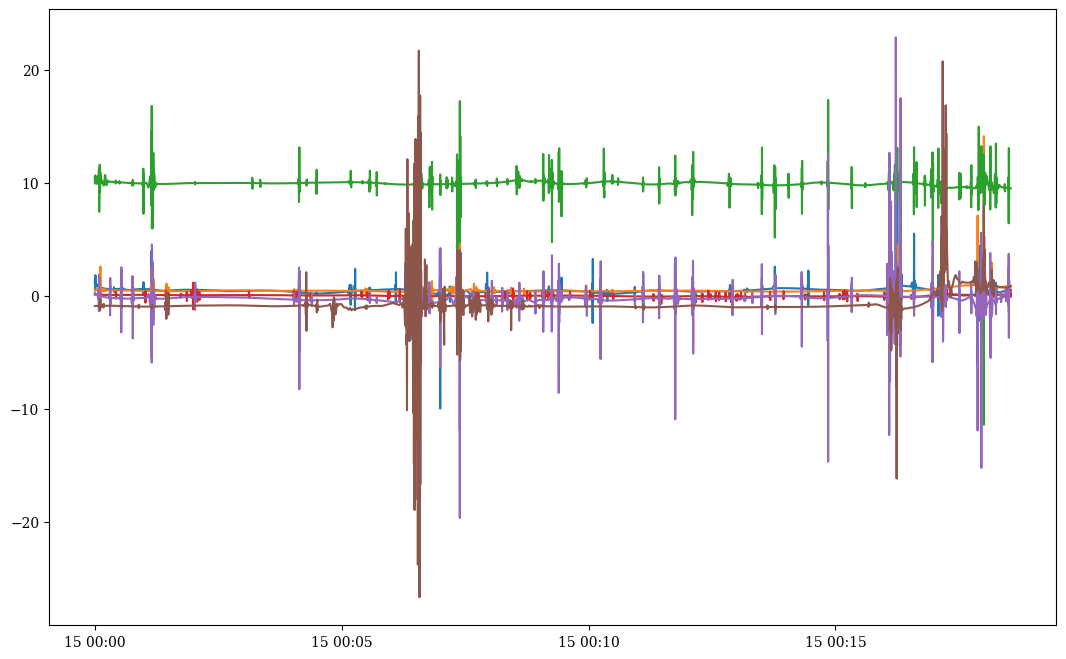

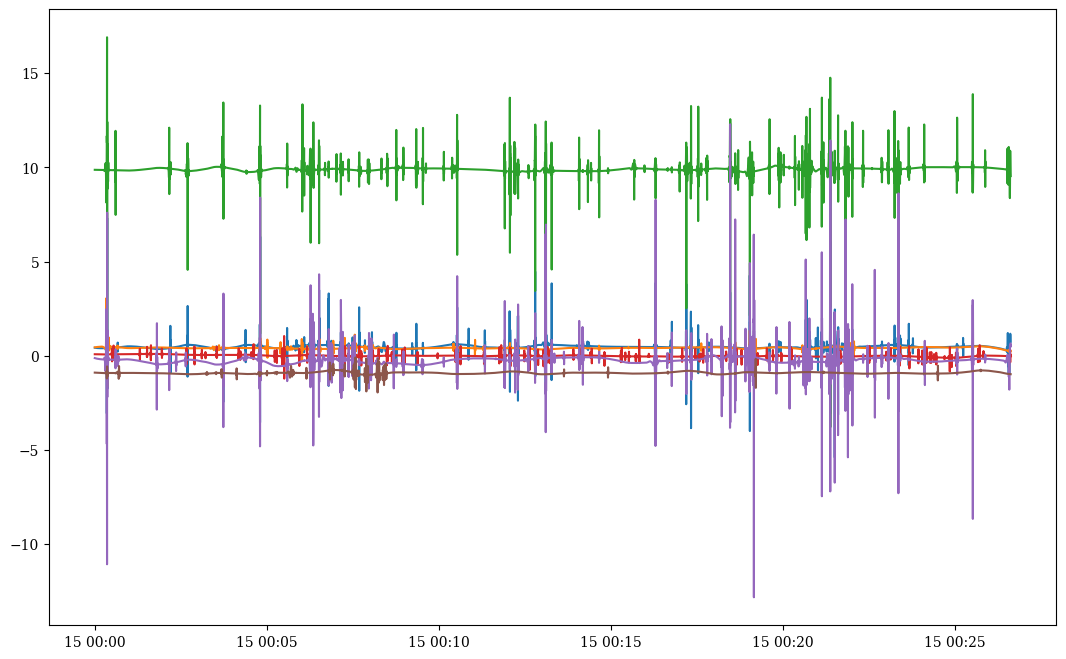

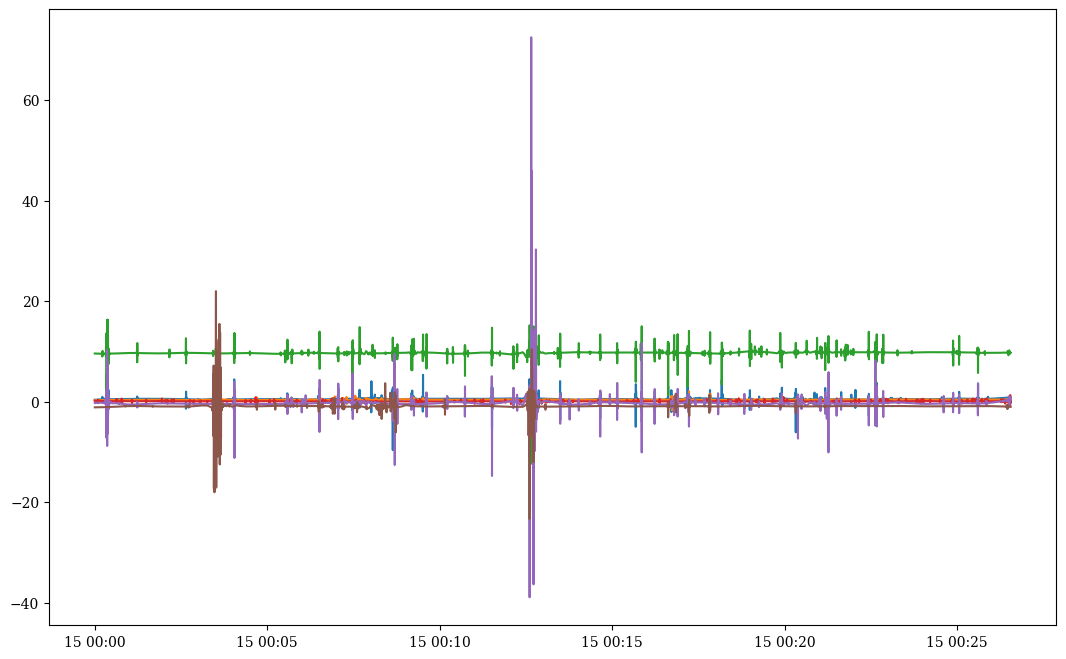

Labels for training: 
Normal  2922
Outlier 2644
% outliers:  47.50269493352498
Labels for testing: 
Normal  7987
Outlier 0
% outliers:  0.0
Labels for evaluation: 
Normal  7562
Outlier 405
% outliers:  5.0834693109074935
Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5839 - loss: 0.7564 - val_accuracy: 0.4374 - val_loss: 0.8186
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6218 - loss: 0.6865 - val_accuracy: 0.4951 - val_loss: 0.7954
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6160 - loss: 0.6991 - val_accuracy: 0.5343 - val_loss: 0.7220
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6302 - loss: 0.6882 - val_accuracy: 0.5734 - val_loss: 0.6464
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6385 - loss: 0.6654 - val_accuracy: 0.5691 - val_loss: 0.6467
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6465 - loss: 0.6739 - val_accuracy: 0.5582 - val_loss: 0.6631
Epoch 7/500

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add, Flatten
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.metrics import classification_report
from skimage.restoration import denoise_wavelet
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
from matplotlib.pyplot import figure
plt.rcParams['font.family'] = 'serif'



# Data Preparation: Feature extraction and Denoising
# Denoising function using wavelet
def denoise(df):
    x = np.array(df)
    x_denoise = denoise_wavelet(x, method='VisuShrink', mode='soft', wavelet_levels=8, wavelet='db4', rescale_sigma=True)
    return x_denoise

# Data Preparation: Feature extraction and Denoising
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation: Feature extraction, Denoising, and Plotting
def data_prep(df):
    # Extracting the relevant feature columns
    df = df.loc[:, ['Ax\n(m/s^2)', 'Ay\n(m/s^2)', 'Az\n(m/s^2)', 'Gx\n(deg/s)', 'Gy\n(deg/s)', 'Gz\n(deg/s)']]

    # Setting the index as a time range with 200ms intervals
    df.index = pd.date_range("0:00", freq="200ms", periods=len(df))

    # Denoising each column
    for col in df.columns:
        df[col] = denoise(df[col])

    # Plotting the data after denoising
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.plot(df.index, df)
    plt.show()

    # Subtracting the mean and taking absolute value for each column
    for col in df.columns:
        df[col] = df[col] - df[col].mean()
        df[col] = df[col].abs()

    return df


# PCA for Dimensionality Reduction
def pca_scaler(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    return X_pca

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # Multi-head Self-Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)

    # Add & Normalize
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-forward Network (Dense layers)
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)

    # Add & Normalize
    ff_output = Add()([attention_output, ff_output])
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)

    return ff_output

# Full Transformer Model
def create_transformer_model(input_shape, num_heads=4, key_dim=64, ff_dim=256, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # Transformer Encoder Layer
    x = transformer_encoder(inputs, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)

    # Flatten and Fully Connected Output Layer
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Compile the Model
    model = Model(inputs, outputs)
    model.compile(optimizer=AdamW(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Train the Model with EarlyStopping
def train_transformer_model(model, X_train, y_train, n_epochs, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.33, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    return history, model

# Create Data for Transformer Training (Time-Series Segmentation)
def create_data(df, labels, n_time_steps, step, padding=True):
    segments = []
    labels_out = []
    max_index = min(df.shape[0], len(labels))

    for i in range(0, max_index, step):
        if i + n_time_steps > max_index:
            if padding:
                xs = np.pad(df['Ax\n(m/s^2)'].values[i:], (0, n_time_steps - len(df['Ax\n(m/s^2)'].values[i:])), 'constant')
                ys = np.pad(df['Ay\n(m/s^2)'].values[i:], (0, n_time_steps - len(df['Ay\n(m/s^2)'].values[i:])), 'constant')
                zs = np.pad(df['Az\n(m/s^2)'].values[i:], (0, n_time_steps - len(df['Az\n(m/s^2)'].values[i:])), 'constant')
                gxs = np.pad(df['Gx\n(deg/s)'].values[i:], (0, n_time_steps - len(df['Gx\n(deg/s)'].values[i:])), 'constant')
                gys = np.pad(df['Gy\n(deg/s)'].values[i:], (0, n_time_steps - len(df['Gy\n(deg/s)'].values[i:])), 'constant')
                gzs = np.pad(df['Gz\n(deg/s)'].values[i:], (0, n_time_steps - len(df['Gz\n(deg/s)'].values[i:])), 'constant')
            else:
                break
        else:
            xs = df['Ax\n(m/s^2)'].values[i: i + n_time_steps]
            ys = df['Ay\n(m/s^2)'].values[i: i + n_time_steps]
            zs = df['Az\n(m/s^2)'].values[i: i + n_time_steps]
            gxs = df['Gx\n(deg/s)'].values[i: i + n_time_steps]
            gys = df['Gy\n(deg/s)'].values[i: i + n_time_steps]
            gzs = df['Gz\n(deg/s)'].values[i: i + n_time_steps]

        window_labels = labels[i: i + n_time_steps]
        label = window_labels[-1] if len(window_labels) > 0 else 0

        segments.append([xs, ys, zs, gxs, gys, gzs])
        labels_out.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, n_time_steps, 6)
    labels_out = np.asarray(labels_out, dtype=np.float32)
    return reshaped_segments, labels_out

# Load datasets
df1 = pd.read_csv('/content/dataSensor/benchydefect.csv')  # Training Data with normal and abnormal
df2 = pd.read_csv('/content/dataSensor/normalbenchy.csv')  # Testing Data with only normal
df3 = pd.read_csv('/content/dataSensor/SensorDataFile.csv')  # Evaluation Data


# df3['label'] = 0
# df3.loc[df3['Gz\n(deg/s)'] > 0.24, 'label'] = 1

# Extract labels (before processing)


df3pz=df3.copy()
df3pz['label'] = 0
df3pz.loc[df3pz['Gz\n(deg/s)'] > 0.13, 'label'] = 1
df3pz = df3pz[df3pz['label']==1].iloc[:,:-1]
df1 = pd.concat([df1, df3pz], ignore_index=True, sort=False)



# Data Preprocessing (exclude the label for features)
df1p = data_prep(df1)
df2p = data_prep(df2)
df3p = data_prep(df3)

feature_cols = ['Ax\n(m/s^2)', 'Ay\n(m/s^2)', 'Az\n(m/s^2)', 'Gx\n(deg/s)', 'Gy\n(deg/s)', 'Gz\n(deg/s)']

# Extracting the relevant features
X_train = df1p.loc[:, feature_cols]
X_test = df2p.loc[:, feature_cols]
X_eval = df3p.loc[:, feature_cols]

df1p['label'] = 0
df1p.loc[df1p['Gz\n(deg/s)'] > 0.24, 'label'] = 1

df2p['label'] = 0

df3p['label'] = 0
df3p.loc[df3p['Gz\n(deg/s)'] > 0.24, 'label'] = 1

y_train = df1p['label'].values
y_test = df2p['label'].values
y_eval = df3p['label'].values


#########################################
print('Labels for training: ')
print( 'Normal ', len(df1p[df1p['label']==0]))
print('Outlier', len(df1p[df1p['label']==1]))
print('% outliers: ', (len(df1p[df1p['label']==1])/len(df1p['label']))*100)
print('Labels for testing: ')
print( 'Normal ', len(df2p[df2p['label']==0]))
print('Outlier', len(df2p[df2p['label']==1]))
print('% outliers: ', (len(df2p[df2p['label']==1])/len(df2p['label']))*100)

print('Labels for evaluation: ')
print( 'Normal ', len(df3p[df3p['label']==0]))
print('Outlier', len(df3p[df3p['label']==1]))
print('% outliers: ', (len(df3p[df3p['label']==1])/len(df3p['label']))*100)
#######################################


# Time-series segmentation with 'create_data'
n_time_steps = 10
step = 2

X_train_seq, y_train_seq = create_data(X_train, y_train, n_time_steps, step)
X_test_seq, y_test_seq = create_data(X_test, y_test, n_time_steps, step)
X_eval_seq, y_eval_seq = create_data(X_eval, y_eval, n_time_steps, step)

# Create and Train the Transformer model
transformer_model = create_transformer_model((n_time_steps, 6))  # 6 features
history, transformer_model = train_transformer_model(transformer_model, X_train_seq, y_train_seq, n_epochs=500, batch_size=64)

# Evaluate the Transformer Model
loss, accuracy = transformer_model.evaluate(X_test_seq, y_test_seq)
print(f"Transformer Test Accuracy: {accuracy}")

# Evaluate on df3
loss, accuracy = transformer_model.evaluate(X_eval_seq, y_eval_seq)
print(f"Transformer Evaluation Accuracy (df3): {accuracy}")

# Predictions and evaluation metrics
y_pred_prob = transformer_model.predict(X_eval_seq)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_eval_seq, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_eval_seq, y_pred, digits=4))


## Saving Preprocessed Data

In [6]:
df3p['label'].value_counts()

label
0    7562
1     405
Name: count, dtype: int64

In [7]:

#########################################
print('Labels for training: ')
print( 'Normal ', len(df1p[df1p['label']==0]))
print('Outlier', len(df1p[df1p['label']==1]))
print('% outliers: ', (len(df1p[df1p['label']==1])/len(df1p['label']))*100)
print('Labels for testing: ')
print( 'Normal ', len(df2p[df2p['label']==0]))
print('Outlier', len(df2p[df2p['label']==1]))
print('% outliers: ', (len(df2p[df2p['label']==1])/len(df2p['label']))*100)

print('Labels for evaluation: ')
print( 'Normal ', len(df3p[df3p['label']==0]))
print('Outlier', len(df3p[df3p['label']==1]))
print('% outliers: ', (len(df3p[df3p['label']==1])/len(df3p['label']))*100)

Labels for training: 
Normal  2922
Outlier 2644
% outliers:  47.50269493352498
Labels for testing: 
Normal  7987
Outlier 0
% outliers:  0.0
Labels for evaluation: 
Normal  7562
Outlier 405
% outliers:  5.0834693109074935


In [8]:
df1p_csv = df1p.to_csv('train.csv',index=False)
df2p_csv = df2p.to_csv('test.csv',index=False)
df3p_csv = df3p.to_csv('eval.csv',index=False)

# GRU Units

## Proposed EEMTL Model (64/32)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 6, 64)     │     12,864 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 32)        │      9,408 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_1[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_1[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.5562 - anomaly_output_loss: 0.6891 - future_output_loss: 0.0270 - loss: 0.7161 - val_anomaly_output_accuracy: 0.8474 - val_anomaly_output_loss: 0.6336 - val_future_output_loss: 0.0614 - val_loss: 0.6955 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.5939 - anomaly_output_loss: 0.6665 - future_output_loss: 0.0146 - loss: 0.6812 - val_anomaly_output_accuracy: 0.9255 - val_anomaly_output_loss: 0.4394 - val_future_output_loss: 0.0545 - val_loss: 0.5016 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.6075 - anomaly_output_loss: 0.6435 - future_output_loss: 0.0108 - loss: 0.6543 - val_anomaly_output_accuracy: 0.9506 - val_anomaly_output_loss: 0.3704 - val_future_output_loss: 0.0447 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_outpu

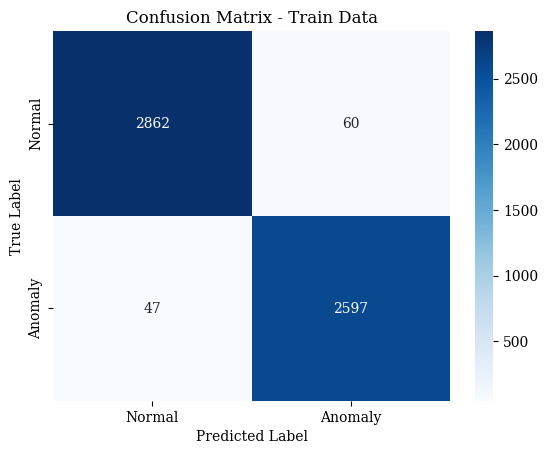


Classification Report:
              precision    recall  f1-score   support

           0     0.9838    0.9795    0.9816      2922
           1     0.9774    0.9822    0.9798      2644

    accuracy                         0.9808      5566
   macro avg     0.9806    0.9808    0.9807      5566
weighted avg     0.9808    0.9808    0.9808      5566


Test Data Evaluation:


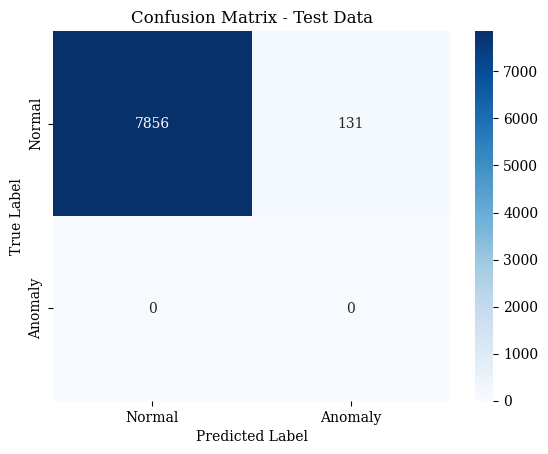


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9836    0.9917      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9836      7987
   macro avg     0.5000    0.4918    0.4959      7987
weighted avg     1.0000    0.9836    0.9917      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


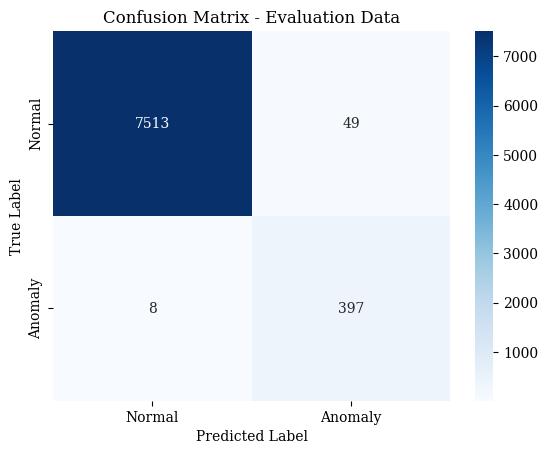


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9935    0.9962      7562
           1     0.8901    0.9802    0.9330       405

    accuracy                         0.9928      7967
   macro avg     0.9445    0.9869    0.9646      7967
weighted avg     0.9934    0.9928    0.9930      7967



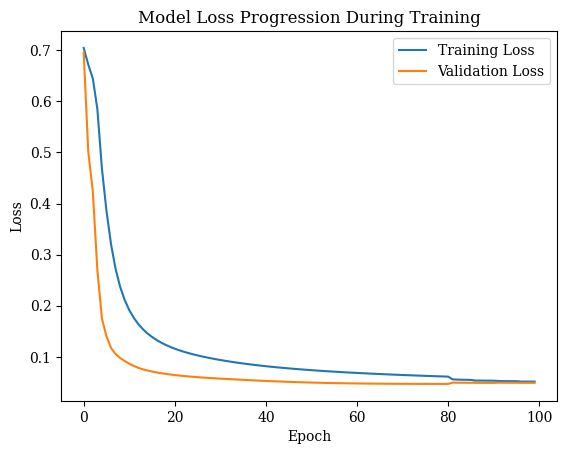

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 64/16

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 6, 64)     │     12,864 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 16)        │      3,936 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         17 │ gru_3[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        102 │ gru_3[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,919 (66.09 KB)

 Trainable params: 16,919 (66.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - anomaly_output_accuracy: 0.5619 - anomaly_output_loss: 0.6883 - future_output_loss: 0.0318 - loss: 0.7201 - val_anomaly_output_accuracy: 0.5287 - val_anomaly_output_loss: 0.6724 - val_future_output_loss: 0.0867 - val_loss: 0.7565 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.5810 - anomaly_output_loss: 0.6748 - future_output_loss: 0.0165 - loss: 0.6913 - val_anomaly_output_accuracy: 0.8618 - val_anomaly_output_loss: 0.5553 - val_future_output_loss: 0.0966 - val_loss: 0.6536 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - anomaly_output_accuracy: 0.5999 - anomaly_output_loss: 0.6585 - future_output_loss: 0.0144 - loss: 0.6729 - val_anomaly_output_accuracy: 0.9201 - val_anomaly_output_loss: 0.4619 - val_future_output_loss: 0.0781 - val_loss: 0.5454 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - anomaly_outpu

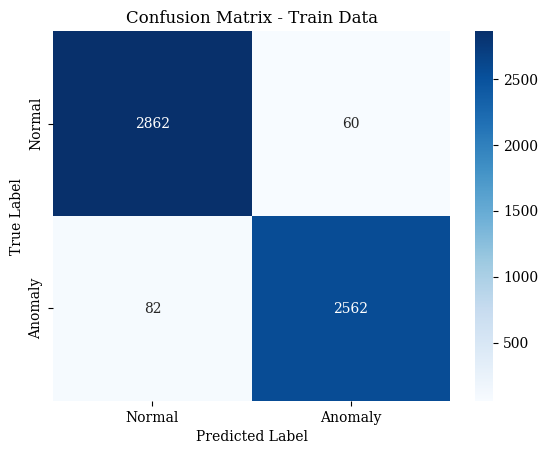


Classification Report:
              precision    recall  f1-score   support

           0     0.9721    0.9795    0.9758      2922
           1     0.9771    0.9690    0.9730      2644

    accuracy                         0.9745      5566
   macro avg     0.9746    0.9742    0.9744      5566
weighted avg     0.9745    0.9745    0.9745      5566


Test Data Evaluation:


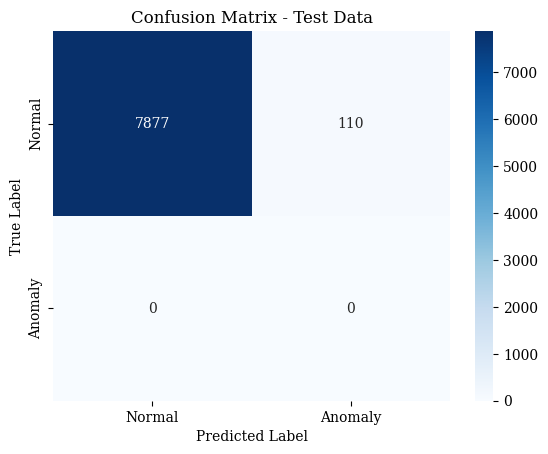


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


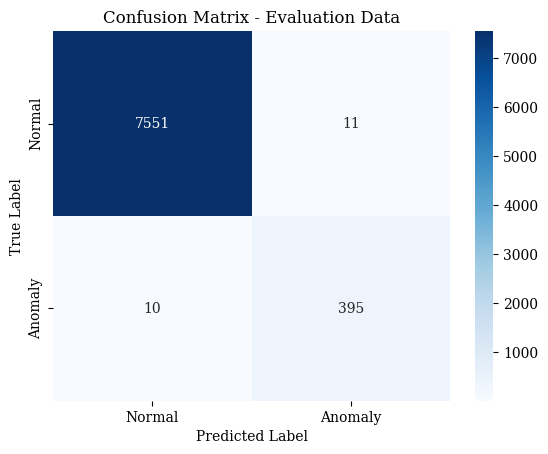


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9985    0.9986      7562
           1     0.9729    0.9753    0.9741       405

    accuracy                         0.9974      7967
   macro avg     0.9858    0.9869    0.9864      7967
weighted avg     0.9974    0.9974    0.9974      7967



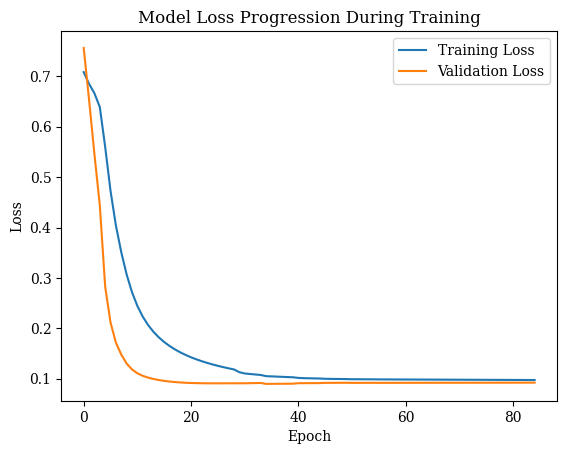

In [10]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    gru_out2 = GRU(16, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 16/16

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 6, 16)     │        912 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 16)        │      1,632 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         17 │ gru_5[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        102 │ gru_5[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,663 (10.40 KB)

 Trainable params: 2,663 (10.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5366 - anomaly_output_loss: 0.6905 - future_output_loss: 0.0407 - loss: 0.7312 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7073 - val_future_output_loss: 0.0999 - val_loss: 0.8021 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5577 - anomaly_output_loss: 0.6833 - future_output_loss: 0.0210 - loss: 0.7044 - val_anomaly_output_accuracy: 0.5404 - val_anomaly_output_loss: 0.6677 - val_future_output_loss: 0.0945 - val_loss: 0.7591 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5804 - anomaly_output_loss: 0.6752 - future_output_loss: 0.0178 - loss: 0.6931 - val_anomaly_output_accuracy: 0.8609 - val_anomaly_output_loss: 0.5900 - val_future_output_loss: 0.0901 - val_loss: 0.6806 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

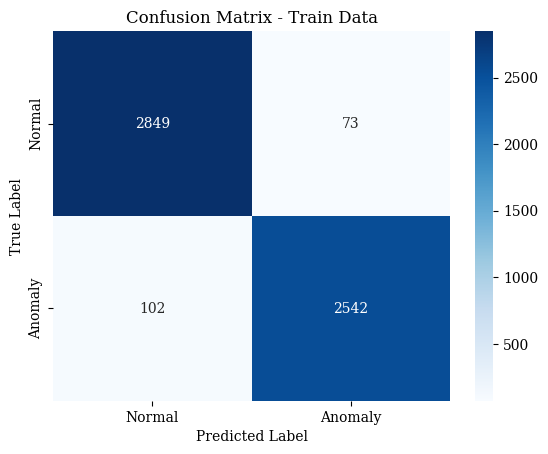


Classification Report:
              precision    recall  f1-score   support

           0     0.9654    0.9750    0.9702      2922
           1     0.9721    0.9614    0.9667      2644

    accuracy                         0.9686      5566
   macro avg     0.9688    0.9682    0.9685      5566
weighted avg     0.9686    0.9686    0.9686      5566


Test Data Evaluation:


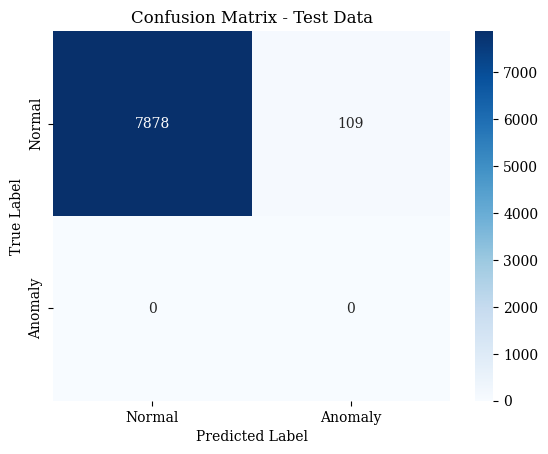


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9864    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9864      7987
   macro avg     0.5000    0.4932    0.4966      7987
weighted avg     1.0000    0.9864    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


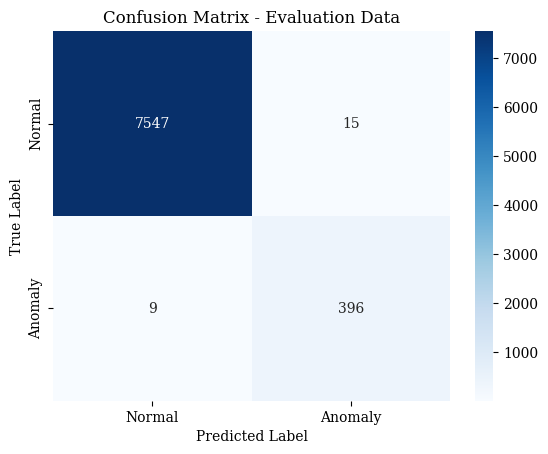


Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9980    0.9984      7562
           1     0.9635    0.9778    0.9706       405

    accuracy                         0.9970      7967
   macro avg     0.9812    0.9879    0.9845      7967
weighted avg     0.9970    0.9970    0.9970      7967



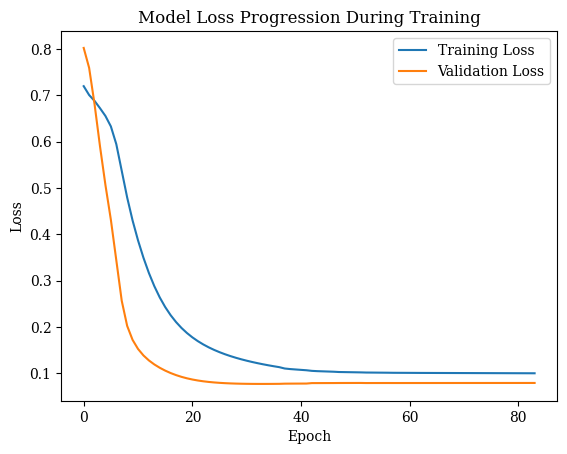

In [11]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(16, return_sequences=True)(inputs)
    gru_out2 = GRU(16, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 32/16

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 6, 32)     │      3,360 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 16)        │      2,400 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         17 │ gru_7[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        102 │ gru_7[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,879 (22.96 KB)

 Trainable params: 5,879 (22.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5402 - anomaly_output_loss: 0.6897 - future_output_loss: 0.0308 - loss: 0.7205 - val_anomaly_output_accuracy: 0.3905 - val_anomaly_output_loss: 0.6930 - val_future_output_loss: 0.0768 - val_loss: 0.7667 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5705 - anomaly_output_loss: 0.6792 - future_output_loss: 0.0166 - loss: 0.6959 - val_anomaly_output_accuracy: 0.8600 - val_anomaly_output_loss: 0.5984 - val_future_output_loss: 0.0827 - val_loss: 0.6818 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5960 - anomaly_output_loss: 0.6646 - future_output_loss: 0.0141 - loss: 0.6787 - val_anomaly_output_accuracy: 0.8941 - val_anomaly_output_loss: 0.4954 - val_future_output_loss: 0.0775 - val_loss: 0.5775 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

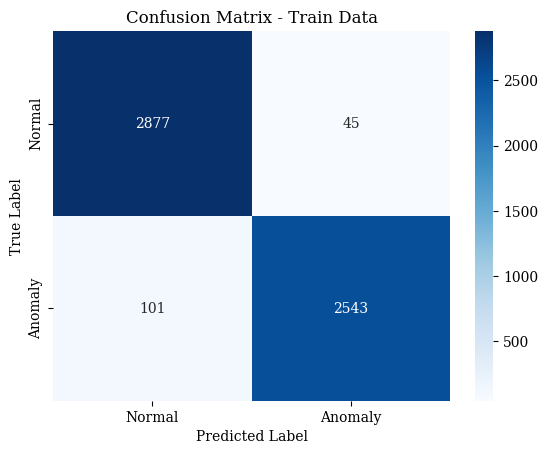


Classification Report:
              precision    recall  f1-score   support

           0     0.9661    0.9846    0.9753      2922
           1     0.9826    0.9618    0.9721      2644

    accuracy                         0.9738      5566
   macro avg     0.9743    0.9732    0.9737      5566
weighted avg     0.9739    0.9738    0.9738      5566


Test Data Evaluation:


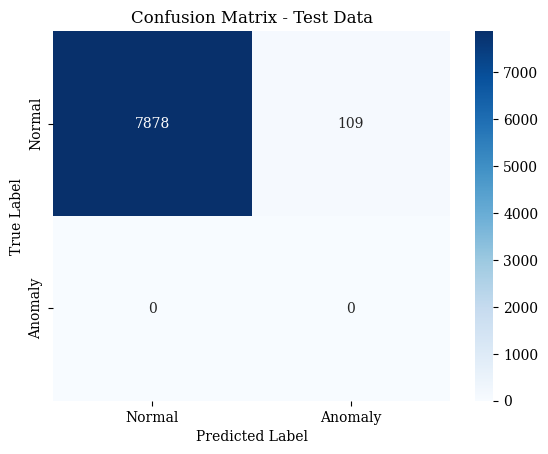


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9864    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9864      7987
   macro avg     0.5000    0.4932    0.4966      7987
weighted avg     1.0000    0.9864    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


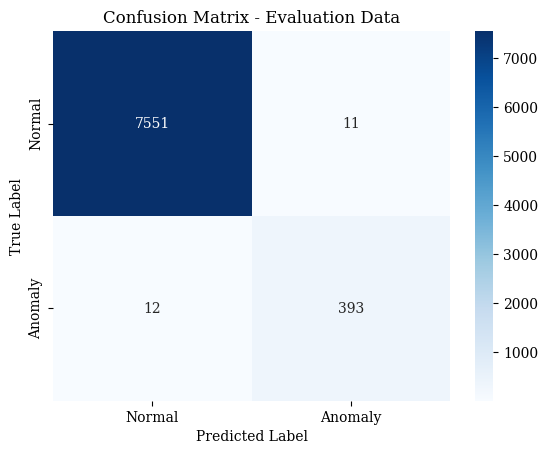


Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9985    0.9985      7562
           1     0.9728    0.9704    0.9716       405

    accuracy                         0.9971      7967
   macro avg     0.9856    0.9845    0.9850      7967
weighted avg     0.9971    0.9971    0.9971      7967



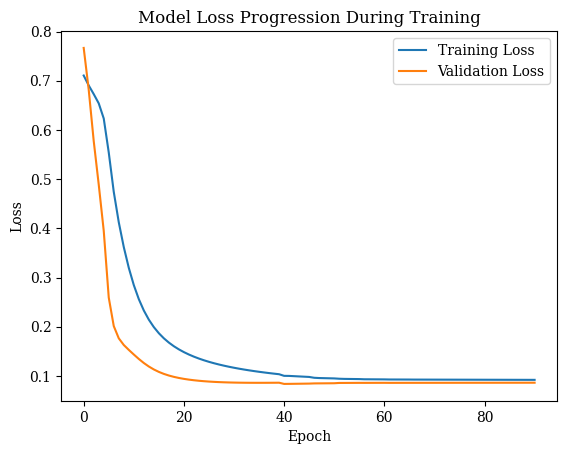

In [12]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(32, return_sequences=True)(inputs)
    gru_out2 = GRU(16, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 32/8

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 6, 32)     │      3,360 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 8)         │      1,008 │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │          9 │ gru_9[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │         54 │ gru_9[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,431 (17.31 KB)

 Trainable params: 4,431 (17.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6921 - future_output_loss: 0.0355 - loss: 0.7276 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7235 - val_future_output_loss: 0.0888 - val_loss: 0.8071 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - anomaly_output_accuracy: 0.5558 - anomaly_output_loss: 0.6860 - future_output_loss: 0.0189 - loss: 0.7049 - val_anomaly_output_accuracy: 0.4704 - val_anomaly_output_loss: 0.6802 - val_future_output_loss: 0.0925 - val_loss: 0.7693 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5657 - anomaly_output_loss: 0.6789 - future_output_loss: 0.0168 - loss: 0.6956 - val_anomaly_output_accuracy: 0.8294 - val_anomaly_output_loss: 0.6154 - val_future_output_loss: 0.1096 - val_loss: 0.7235 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

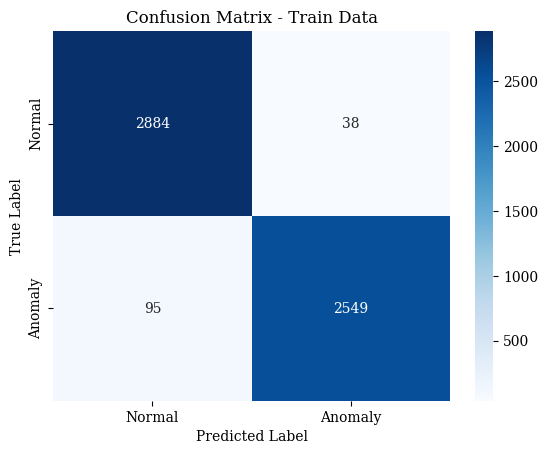


Classification Report:
              precision    recall  f1-score   support

           0     0.9681    0.9870    0.9775      2922
           1     0.9853    0.9641    0.9746      2644

    accuracy                         0.9761      5566
   macro avg     0.9767    0.9755    0.9760      5566
weighted avg     0.9763    0.9761    0.9761      5566


Test Data Evaluation:


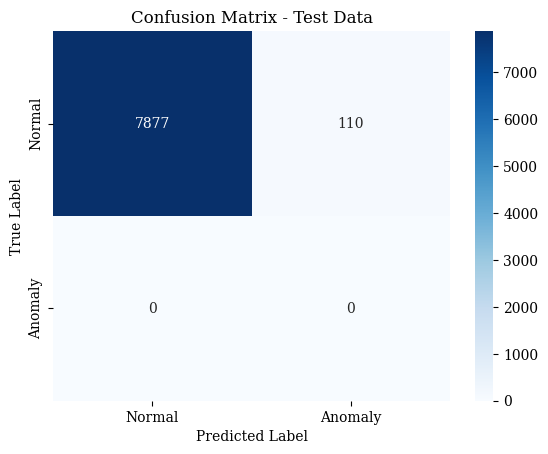


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


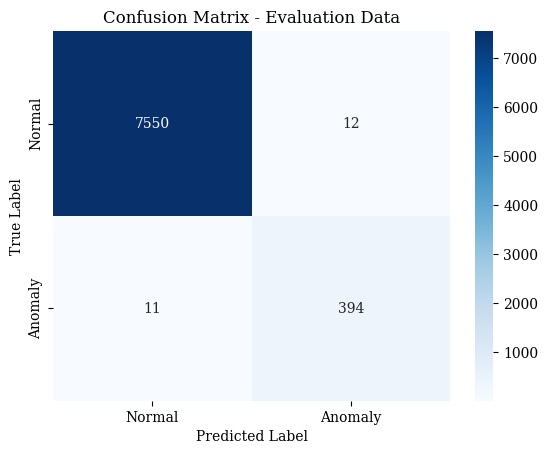


Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9984    0.9985      7562
           1     0.9704    0.9728    0.9716       405

    accuracy                         0.9971      7967
   macro avg     0.9845    0.9856    0.9851      7967
weighted avg     0.9971    0.9971    0.9971      7967



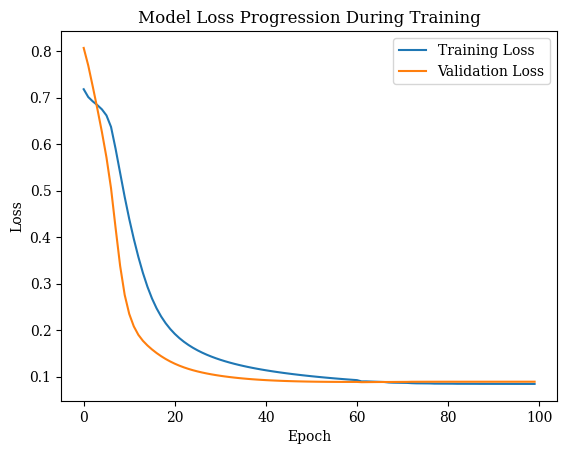

In [13]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(32, return_sequences=True)(inputs)
    gru_out2 = GRU(8, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 16/8

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 6, 16)     │        912 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 8)         │        624 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │          9 │ gru_11[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │         54 │ gru_11[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,599 (6.25 KB)

 Trainable params: 1,599 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - anomaly_output_accuracy: 0.5496 - anomaly_output_loss: 0.6908 - future_output_loss: 0.0380 - loss: 0.7288 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.6981 - val_future_output_loss: 0.1033 - val_loss: 0.7971 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5582 - anomaly_output_loss: 0.6843 - future_output_loss: 0.0207 - loss: 0.7050 - val_anomaly_output_accuracy: 0.5027 - val_anomaly_output_loss: 0.6761 - val_future_output_loss: 0.0910 - val_loss: 0.7640 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5744 - anomaly_output_loss: 0.6778 - future_output_loss: 0.0176 - loss: 0.6953 - val_anomaly_output_accuracy: 0.8492 - val_anomaly_output_loss: 0.6248 - val_future_output_loss: 0.0999 - val_loss: 0.7233 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

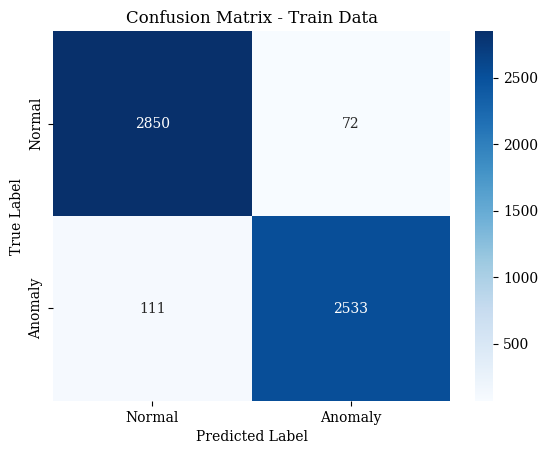


Classification Report:
              precision    recall  f1-score   support

           0     0.9625    0.9754    0.9689      2922
           1     0.9724    0.9580    0.9651      2644

    accuracy                         0.9671      5566
   macro avg     0.9674    0.9667    0.9670      5566
weighted avg     0.9672    0.9671    0.9671      5566


Test Data Evaluation:


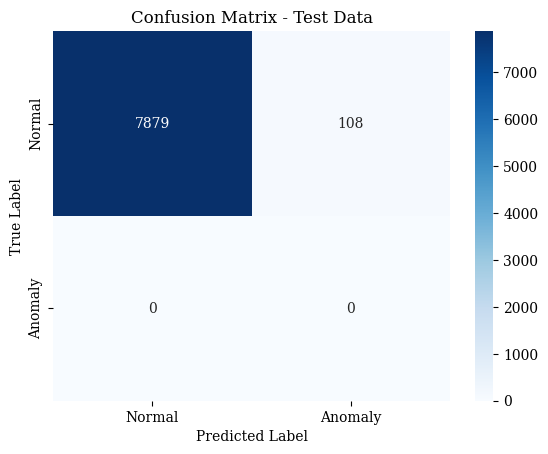


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9865    0.9932      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9865      7987
   macro avg     0.5000    0.4932    0.4966      7987
weighted avg     1.0000    0.9865    0.9932      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


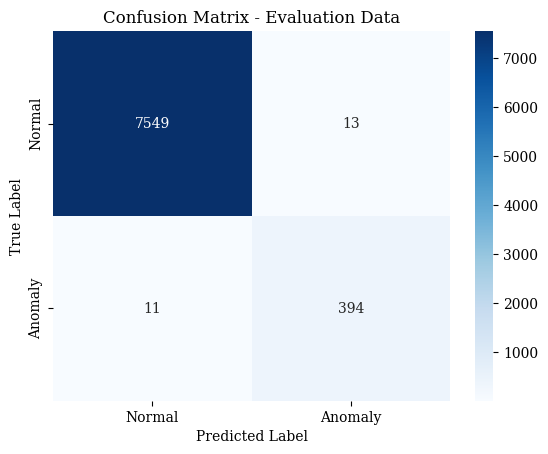


Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9983    0.9984      7562
           1     0.9681    0.9728    0.9704       405

    accuracy                         0.9970      7967
   macro avg     0.9833    0.9856    0.9844      7967
weighted avg     0.9970    0.9970    0.9970      7967



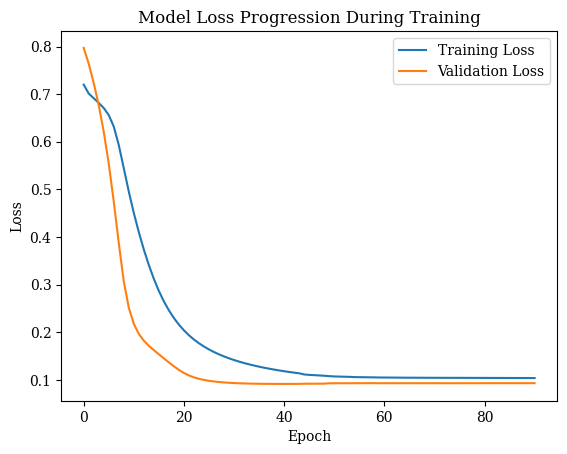

In [14]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(16, return_sequences=True)(inputs)
    gru_out2 = GRU(8, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 8/8

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 6, 8)      │        264 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ (None, 8)         │        432 │ gru_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │          9 │ gru_13[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │         54 │ gru_13[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 759 (2.96 KB)

 Trainable params: 759 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5896 - anomaly_output_loss: 0.6910 - future_output_loss: 0.0385 - loss: 0.7295 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7003 - val_future_output_loss: 0.1069 - val_loss: 0.8026 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6861 - future_output_loss: 0.0221 - loss: 0.7082 - val_anomaly_output_accuracy: 0.3842 - val_anomaly_output_loss: 0.6988 - val_future_output_loss: 0.0872 - val_loss: 0.7820 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5599 - anomaly_output_loss: 0.6825 - future_output_loss: 0.0189 - loss: 0.7014 - val_anomaly_output_accuracy: 0.5215 - val_anomaly_output_loss: 0.6729 - val_future_output_loss: 0.0849 - val_loss: 0.7549 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

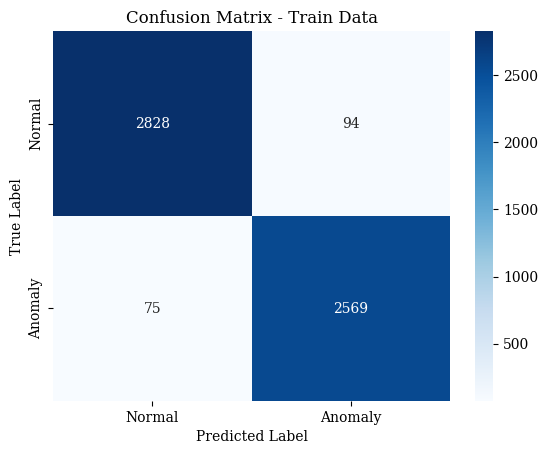


Classification Report:
              precision    recall  f1-score   support

           0     0.9742    0.9678    0.9710      2922
           1     0.9647    0.9716    0.9682      2644

    accuracy                         0.9696      5566
   macro avg     0.9694    0.9697    0.9696      5566
weighted avg     0.9697    0.9696    0.9696      5566


Test Data Evaluation:


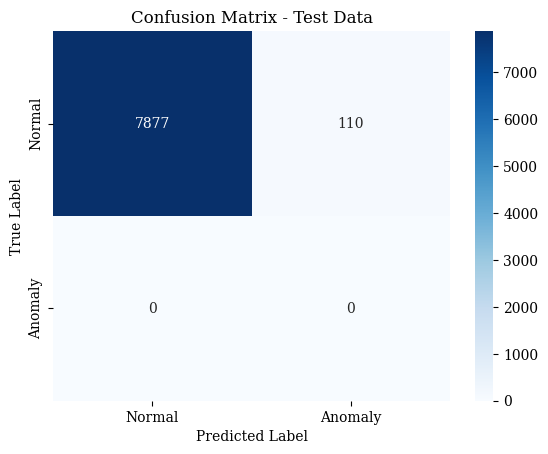


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


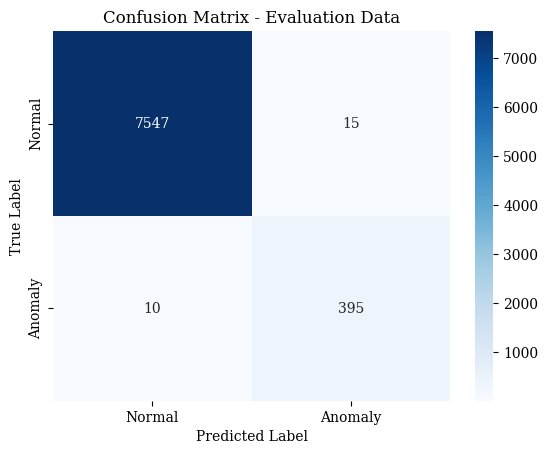


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9980    0.9983      7562
           1     0.9634    0.9753    0.9693       405

    accuracy                         0.9969      7967
   macro avg     0.9810    0.9867    0.9838      7967
weighted avg     0.9969    0.9969    0.9969      7967



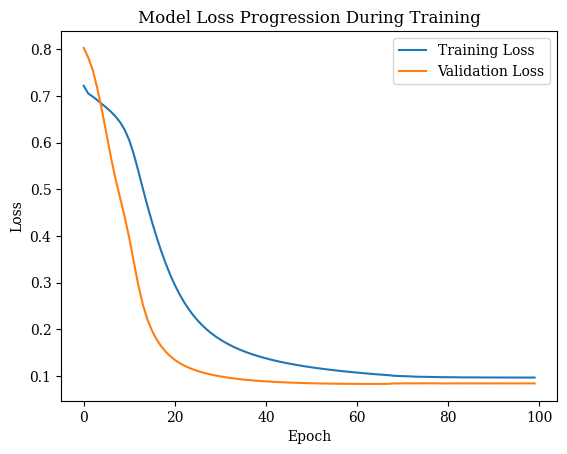

In [15]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(8, return_sequences=True)(inputs)
    gru_out2 = GRU(8, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 32/32

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 6, 32)     │      3,360 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 32)        │      6,336 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_15[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_15[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,927 (38.78 KB)

 Trainable params: 9,927 (38.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.5661 - anomaly_output_loss: 0.6884 - future_output_loss: 0.0304 - loss: 0.7188 - val_anomaly_output_accuracy: 0.4910 - val_anomaly_output_loss: 0.6793 - val_future_output_loss: 0.0759 - val_loss: 0.7527 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.5801 - anomaly_output_loss: 0.6746 - future_output_loss: 0.0166 - loss: 0.6911 - val_anomaly_output_accuracy: 0.8689 - val_anomaly_output_loss: 0.5292 - val_future_output_loss: 0.0678 - val_loss: 0.6014 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - anomaly_output_accuracy: 0.5976 - anomaly_output_loss: 0.6561 - future_output_loss: 0.0131 - loss: 0.6692 - val_anomaly_output_accuracy: 0.9228 - val_anomaly_output_loss: 0.4445 - val_future_output_loss: 0.0559 - val_loss: 0.5081 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

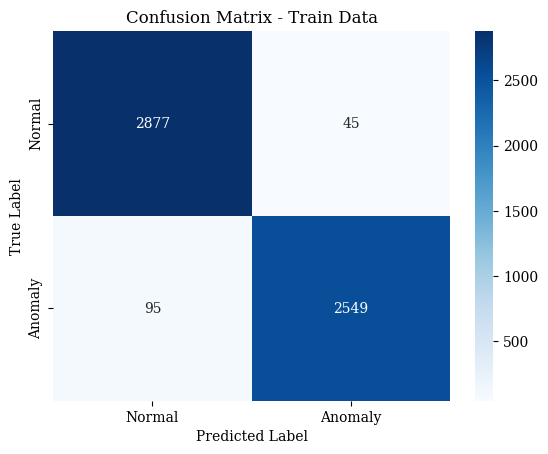


Classification Report:
              precision    recall  f1-score   support

           0     0.9680    0.9846    0.9762      2922
           1     0.9827    0.9641    0.9733      2644

    accuracy                         0.9748      5566
   macro avg     0.9753    0.9743    0.9748      5566
weighted avg     0.9750    0.9748    0.9748      5566


Test Data Evaluation:


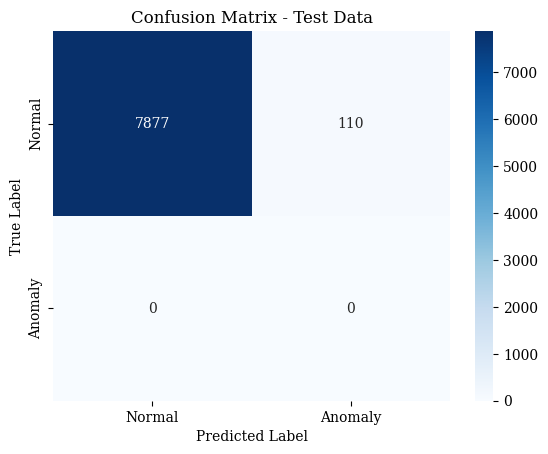


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


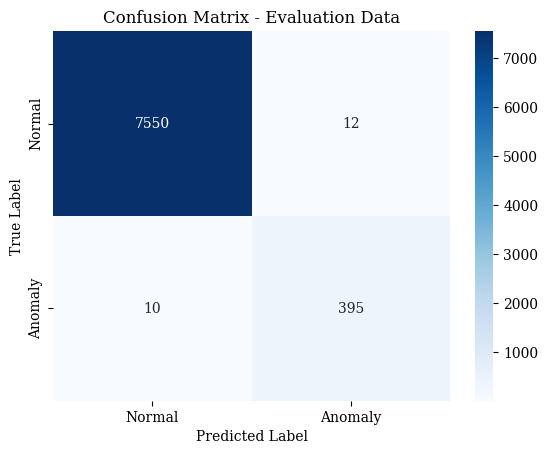


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9984    0.9985      7562
           1     0.9705    0.9753    0.9729       405

    accuracy                         0.9972      7967
   macro avg     0.9846    0.9869    0.9857      7967
weighted avg     0.9972    0.9972    0.9972      7967



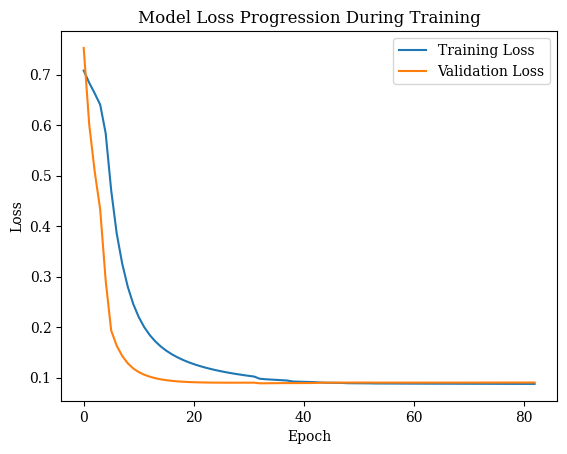

In [16]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(32, return_sequences=True)(inputs)
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 64/64

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ (None, 64)        │     24,960 │ gru_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         65 │ gru_17[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        390 │ gru_17[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,279 (149.53 KB)

 Trainable params: 38,279 (149.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - anomaly_output_accuracy: 0.5989 - anomaly_output_loss: 0.6859 - future_output_loss: 0.0253 - loss: 0.7112 - val_anomaly_output_accuracy: 0.8627 - val_anomaly_output_loss: 0.5552 - val_future_output_loss: 0.0630 - val_loss: 0.6218 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5964 - anomaly_output_loss: 0.6588 - future_output_loss: 0.0124 - loss: 0.6712 - val_anomaly_output_accuracy: 0.9318 - val_anomaly_output_loss: 0.4401 - val_future_output_loss: 0.0499 - val_loss: 0.4981 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.6235 - anomaly_output_loss: 0.6312 - future_output_loss: 0.0103 - loss: 0.6415 - val_anomaly_output_accuracy: 0.9659 - val_anomaly_output_loss: 0.3119 - val_future_output_loss: 0.0547 - val_loss: 0.3744 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_outpu

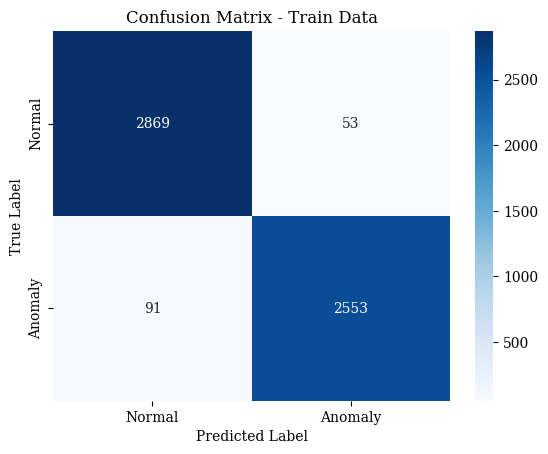


Classification Report:
              precision    recall  f1-score   support

           0     0.9693    0.9819    0.9755      2922
           1     0.9797    0.9656    0.9726      2644

    accuracy                         0.9741      5566
   macro avg     0.9745    0.9737    0.9740      5566
weighted avg     0.9742    0.9741    0.9741      5566


Test Data Evaluation:


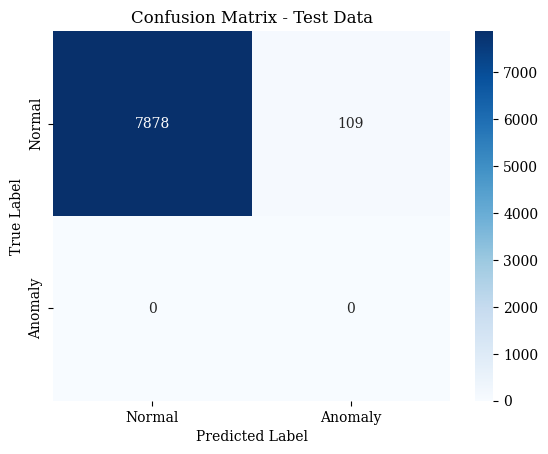


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9864    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9864      7987
   macro avg     0.5000    0.4932    0.4966      7987
weighted avg     1.0000    0.9864    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


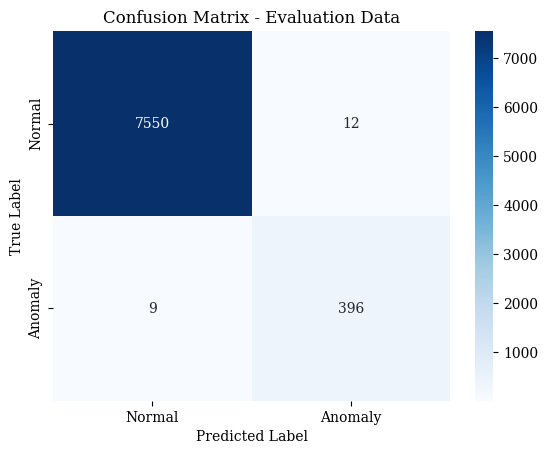


Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9984    0.9986      7562
           1     0.9706    0.9778    0.9742       405

    accuracy                         0.9974      7967
   macro avg     0.9847    0.9881    0.9864      7967
weighted avg     0.9974    0.9974    0.9974      7967



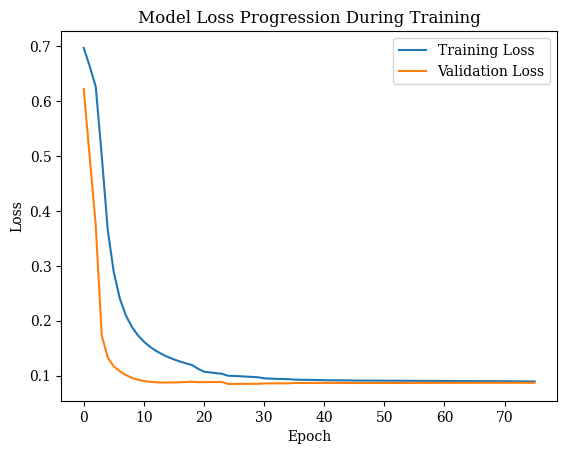

In [17]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    gru_out2 = GRU(64, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 32/64

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 6, 32)     │      3,360 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 64)        │     18,816 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         65 │ gru_19[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        390 │ gru_19[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,631 (88.40 KB)

 Trainable params: 22,631 (88.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.5567 - anomaly_output_loss: 0.6894 - future_output_loss: 0.0298 - loss: 0.7192 - val_anomaly_output_accuracy: 0.7415 - val_anomaly_output_loss: 0.6497 - val_future_output_loss: 0.0613 - val_loss: 0.7106 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5902 - anomaly_output_loss: 0.6692 - future_output_loss: 0.0135 - loss: 0.6827 - val_anomaly_output_accuracy: 0.9013 - val_anomaly_output_loss: 0.4835 - val_future_output_loss: 0.0580 - val_loss: 0.5481 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.6036 - anomaly_output_loss: 0.6491 - future_output_loss: 0.0114 - loss: 0.6605 - val_anomaly_output_accuracy: 0.9425 - val_anomaly_output_loss: 0.4068 - val_future_output_loss: 0.0481 - val_loss: 0.4634 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_outpu

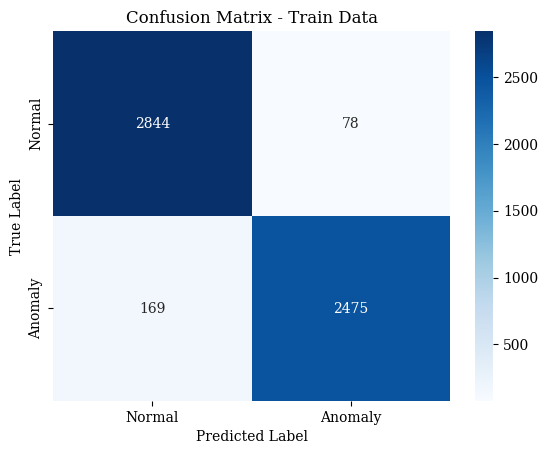


Classification Report:
              precision    recall  f1-score   support

           0     0.9439    0.9733    0.9584      2922
           1     0.9694    0.9361    0.9525      2644

    accuracy                         0.9556      5566
   macro avg     0.9567    0.9547    0.9554      5566
weighted avg     0.9560    0.9556    0.9556      5566


Test Data Evaluation:


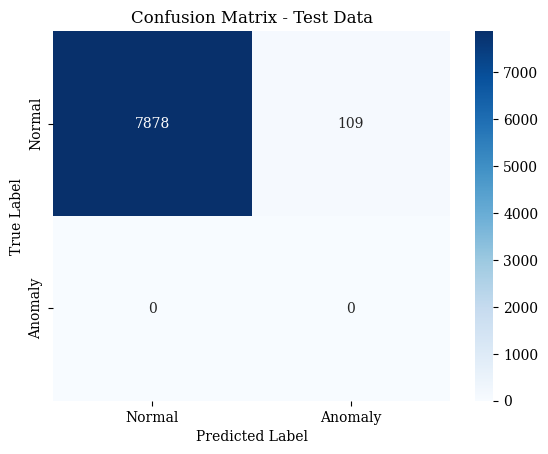


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9864    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9864      7987
   macro avg     0.5000    0.4932    0.4966      7987
weighted avg     1.0000    0.9864    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


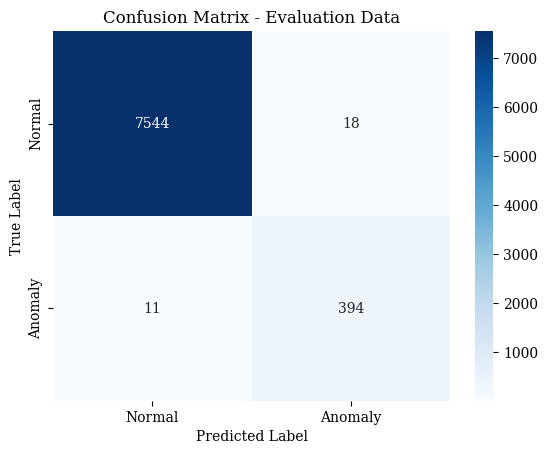


Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9976    0.9981      7562
           1     0.9563    0.9728    0.9645       405

    accuracy                         0.9964      7967
   macro avg     0.9774    0.9852    0.9813      7967
weighted avg     0.9964    0.9964    0.9964      7967



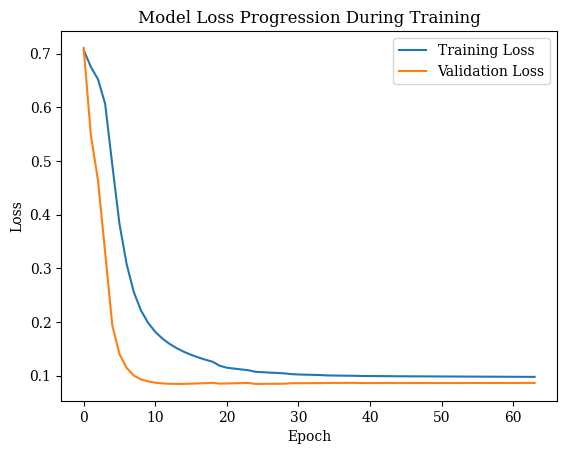

In [18]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(32, return_sequences=True)(inputs)
    gru_out2 = GRU(64, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 8/64

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 6, 8)      │        264 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ (None, 64)        │     14,208 │ gru_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         65 │ gru_21[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        390 │ gru_21[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,927 (58.31 KB)

 Trainable params: 14,927 (58.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - anomaly_output_accuracy: 0.5724 - anomaly_output_loss: 0.6900 - future_output_loss: 0.0355 - loss: 0.7255 - val_anomaly_output_accuracy: 0.3950 - val_anomaly_output_loss: 0.6968 - val_future_output_loss: 0.0800 - val_loss: 0.7732 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5658 - anomaly_output_loss: 0.6790 - future_output_loss: 0.0172 - loss: 0.6962 - val_anomaly_output_accuracy: 0.8591 - val_anomaly_output_loss: 0.5667 - val_future_output_loss: 0.0628 - val_loss: 0.6325 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.5834 - anomaly_output_loss: 0.6659 - future_output_loss: 0.0133 - loss: 0.6792 - val_anomaly_output_accuracy: 0.9075 - val_anomaly_output_loss: 0.4906 - val_future_output_loss: 0.0562 - val_loss: 0.5532 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_outpu

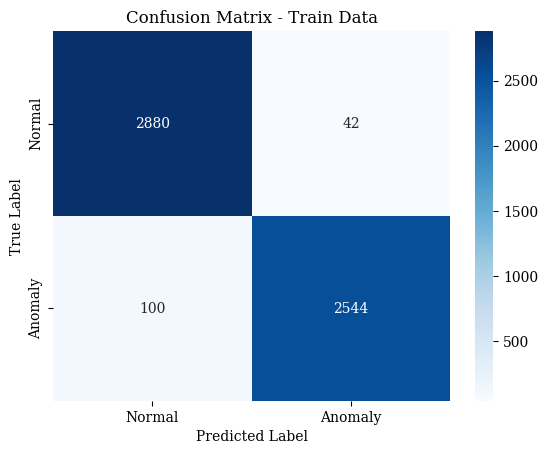


Classification Report:
              precision    recall  f1-score   support

           0     0.9664    0.9856    0.9759      2922
           1     0.9838    0.9622    0.9728      2644

    accuracy                         0.9745      5566
   macro avg     0.9751    0.9739    0.9744      5566
weighted avg     0.9747    0.9745    0.9745      5566


Test Data Evaluation:


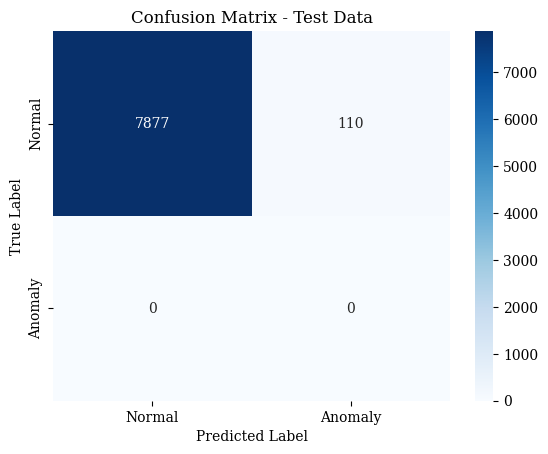


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


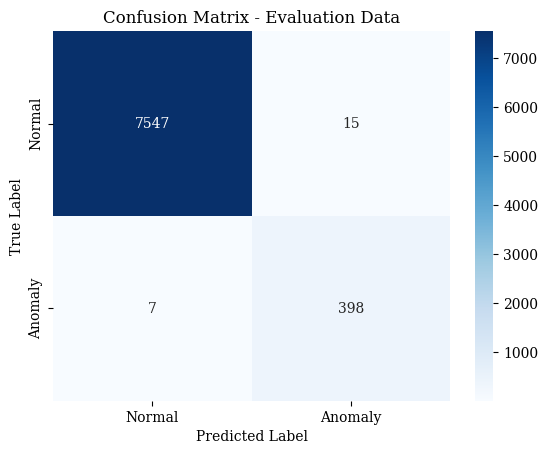


Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9980    0.9985      7562
           1     0.9637    0.9827    0.9731       405

    accuracy                         0.9972      7967
   macro avg     0.9814    0.9904    0.9858      7967
weighted avg     0.9973    0.9972    0.9973      7967



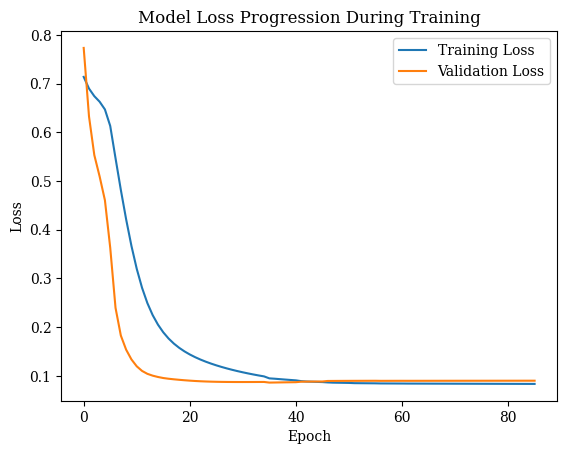

In [19]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(8, return_sequences=True)(inputs)
    gru_out2 = GRU(64, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 16/64

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 6, 16)     │        912 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 64)        │     15,744 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         65 │ gru_23[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        390 │ gru_23[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,111 (66.84 KB)

 Trainable params: 17,111 (66.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6905 - future_output_loss: 0.0318 - loss: 0.7223 - val_anomaly_output_accuracy: 0.4829 - val_anomaly_output_loss: 0.6798 - val_future_output_loss: 0.0646 - val_loss: 0.7425 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.5796 - anomaly_output_loss: 0.6738 - future_output_loss: 0.0144 - loss: 0.6882 - val_anomaly_output_accuracy: 0.8734 - val_anomaly_output_loss: 0.5143 - val_future_output_loss: 0.0616 - val_loss: 0.5809 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.5977 - anomaly_output_loss: 0.6549 - future_output_loss: 0.0118 - loss: 0.6666 - val_anomaly_output_accuracy: 0.9318 - val_anomaly_output_loss: 0.4378 - val_future_output_loss: 0.0500 - val_loss: 0.4955 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_outpu

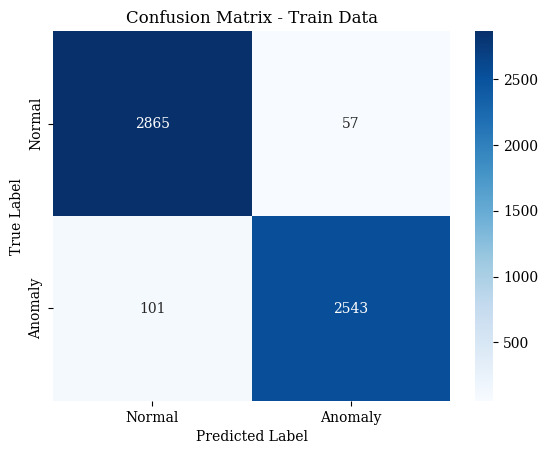


Classification Report:
              precision    recall  f1-score   support

           0     0.9659    0.9805    0.9732      2922
           1     0.9781    0.9618    0.9699      2644

    accuracy                         0.9716      5566
   macro avg     0.9720    0.9711    0.9715      5566
weighted avg     0.9717    0.9716    0.9716      5566


Test Data Evaluation:


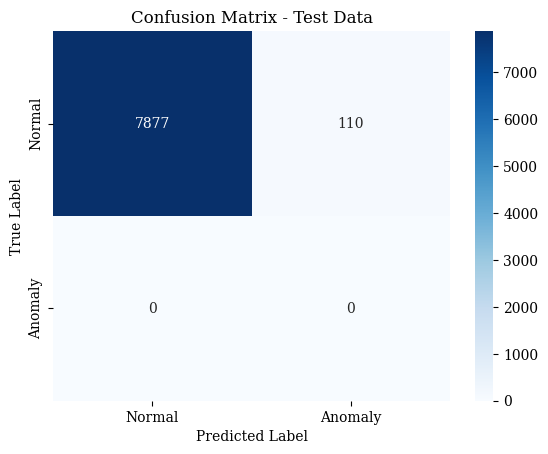


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


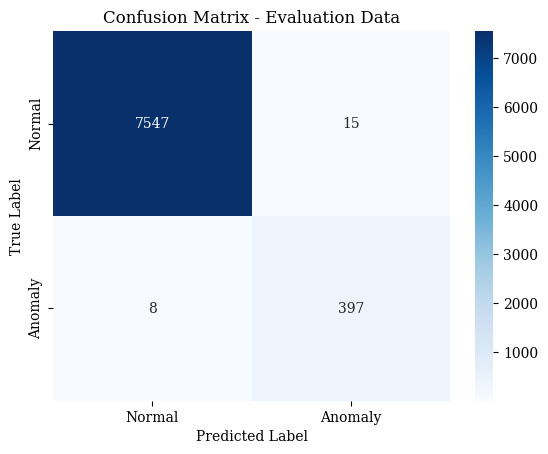


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9980    0.9985      7562
           1     0.9636    0.9802    0.9718       405

    accuracy                         0.9971      7967
   macro avg     0.9813    0.9891    0.9852      7967
weighted avg     0.9971    0.9971    0.9971      7967



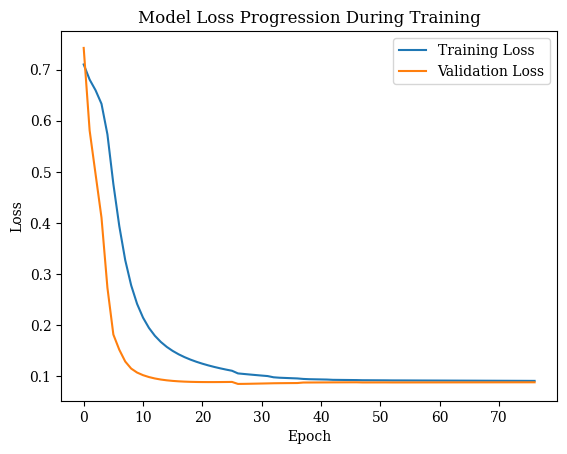

In [20]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(16, return_sequences=True)(inputs)
    gru_out2 = GRU(64, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 8/32

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 6, 8)      │        264 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ (None, 32)        │      4,032 │ gru_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_25[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_25[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,527 (17.68 KB)

 Trainable params: 4,527 (17.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5723 - anomaly_output_loss: 0.6887 - future_output_loss: 0.0393 - loss: 0.7281 - val_anomaly_output_accuracy: 0.3959 - val_anomaly_output_loss: 0.6938 - val_future_output_loss: 0.0906 - val_loss: 0.7804 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5649 - anomaly_output_loss: 0.6805 - future_output_loss: 0.0208 - loss: 0.7014 - val_anomaly_output_accuracy: 0.7379 - val_anomaly_output_loss: 0.6440 - val_future_output_loss: 0.0717 - val_loss: 0.7151 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5853 - anomaly_output_loss: 0.6714 - future_output_loss: 0.0157 - loss: 0.6871 - val_anomaly_output_accuracy: 0.8654 - val_anomaly_output_loss: 0.5389 - val_future_output_loss: 0.0636 - val_loss: 0.6066 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

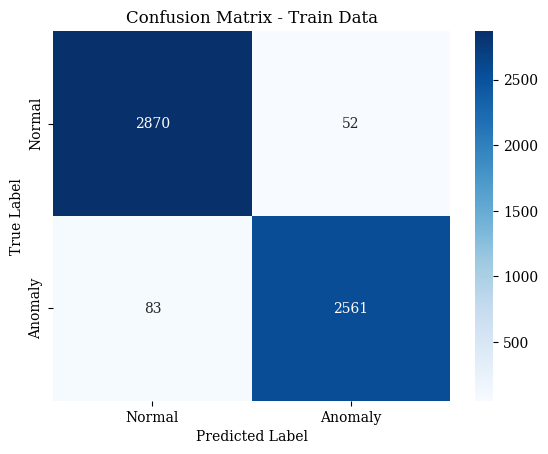


Classification Report:
              precision    recall  f1-score   support

           0     0.9719    0.9822    0.9770      2922
           1     0.9801    0.9686    0.9743      2644

    accuracy                         0.9757      5566
   macro avg     0.9760    0.9754    0.9757      5566
weighted avg     0.9758    0.9757    0.9757      5566


Test Data Evaluation:


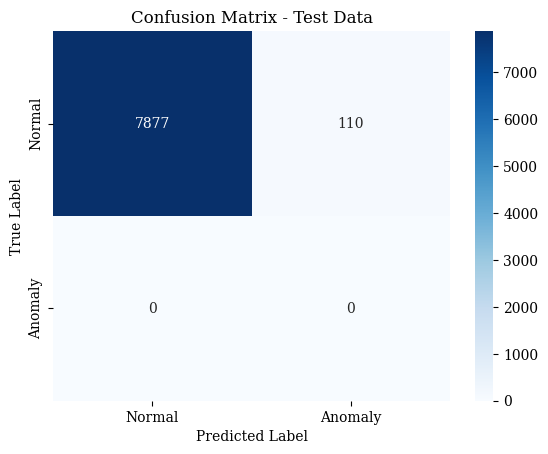


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


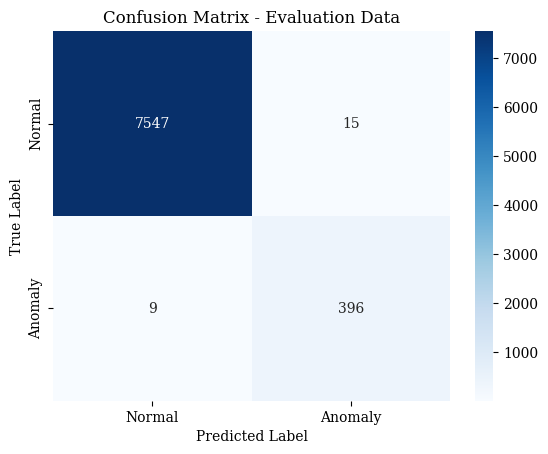


Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9980    0.9984      7562
           1     0.9635    0.9778    0.9706       405

    accuracy                         0.9970      7967
   macro avg     0.9812    0.9879    0.9845      7967
weighted avg     0.9970    0.9970    0.9970      7967



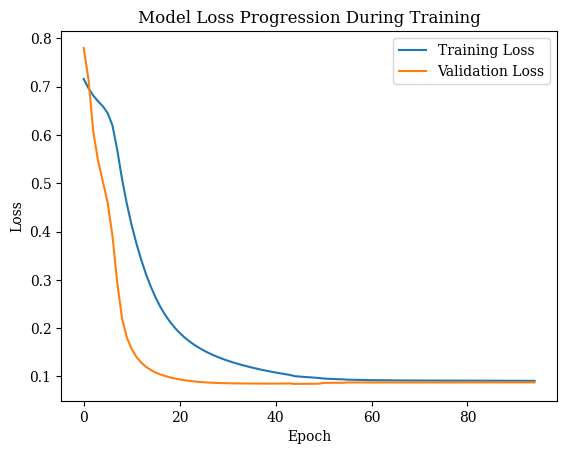

In [21]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(8, return_sequences=True)(inputs)
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 16/32

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 6, 16)     │        912 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 32)        │      4,800 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_27[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_27[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,943 (23.21 KB)

 Trainable params: 5,943 (23.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5426 - anomaly_output_loss: 0.6899 - future_output_loss: 0.0323 - loss: 0.7223 - val_anomaly_output_accuracy: 0.3986 - val_anomaly_output_loss: 0.6935 - val_future_output_loss: 0.0730 - val_loss: 0.7635 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - anomaly_output_accuracy: 0.5700 - anomaly_output_loss: 0.6791 - future_output_loss: 0.0166 - loss: 0.6957 - val_anomaly_output_accuracy: 0.8591 - val_anomaly_output_loss: 0.5852 - val_future_output_loss: 0.0643 - val_loss: 0.6517 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5913 - anomaly_output_loss: 0.6636 - future_output_loss: 0.0135 - loss: 0.6771 - val_anomaly_output_accuracy: 0.8941 - val_anomaly_output_loss: 0.4847 - val_future_output_loss: 0.0602 - val_loss: 0.5510 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - anomaly_outpu

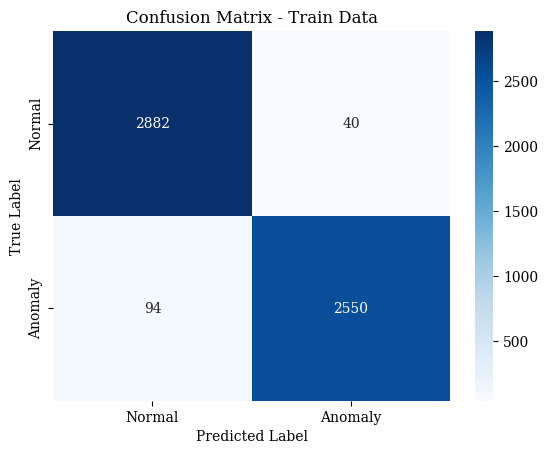


Classification Report:
              precision    recall  f1-score   support

           0     0.9684    0.9863    0.9773      2922
           1     0.9846    0.9644    0.9744      2644

    accuracy                         0.9759      5566
   macro avg     0.9765    0.9754    0.9758      5566
weighted avg     0.9761    0.9759    0.9759      5566


Test Data Evaluation:


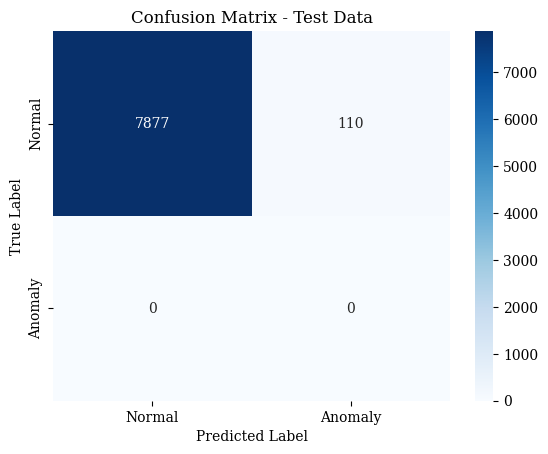


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


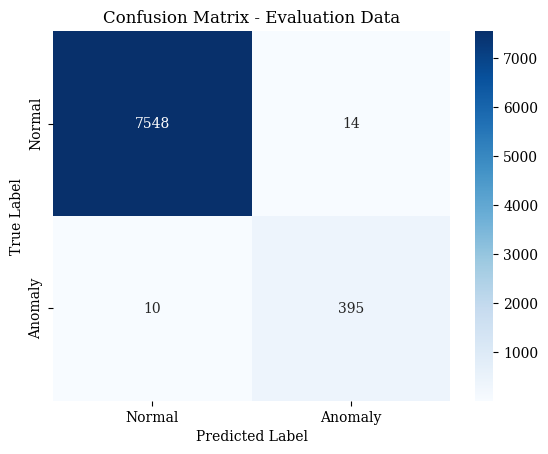


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9981    0.9984      7562
           1     0.9658    0.9753    0.9705       405

    accuracy                         0.9970      7967
   macro avg     0.9822    0.9867    0.9845      7967
weighted avg     0.9970    0.9970    0.9970      7967



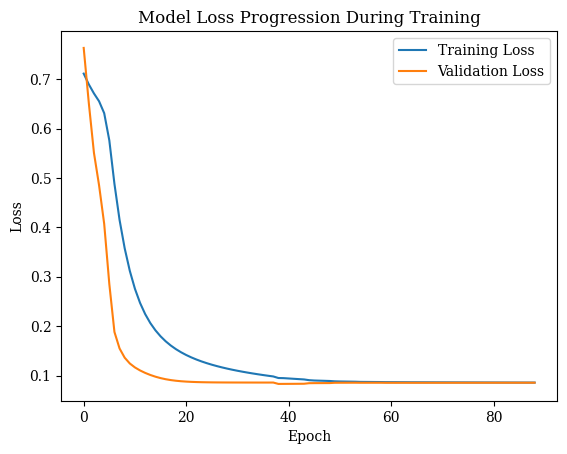

In [22]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(16, return_sequences=True)(inputs)
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## EEMTL 8/16

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4092 - val_loss: 1.0673
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2779 - val_loss: 1.0153
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2687 - val_loss: 0.9964
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2651 - val_loss: 0.9880
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2637 - val_loss: 0.9829
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2626 - val_loss: 0.9827
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 - val_loss: 0.9827
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2620 - val_loss: 0.9860
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_28 (GRU)        │ (None, 6, 8)      │        264 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ (None, 16)        │      1,248 │ gru_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         17 │ gru_29[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        102 │ gru_29[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,631 (6.37 KB)

 Trainable params: 1,631 (6.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6924 - future_output_loss: 0.0367 - loss: 0.7291 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7306 - val_future_output_loss: 0.0899 - val_loss: 0.8149 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6879 - future_output_loss: 0.0211 - loss: 0.7090 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7152 - val_future_output_loss: 0.0834 - val_loss: 0.7940 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_output_accuracy: 0.5560 - anomaly_output_loss: 0.6841 - future_output_loss: 0.0193 - loss: 0.7034 - val_anomaly_output_accuracy: 0.4767 - val_anomaly_output_loss: 0.6799 - val_future_output_loss: 0.0763 - val_loss: 0.7536 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - anomaly_outpu

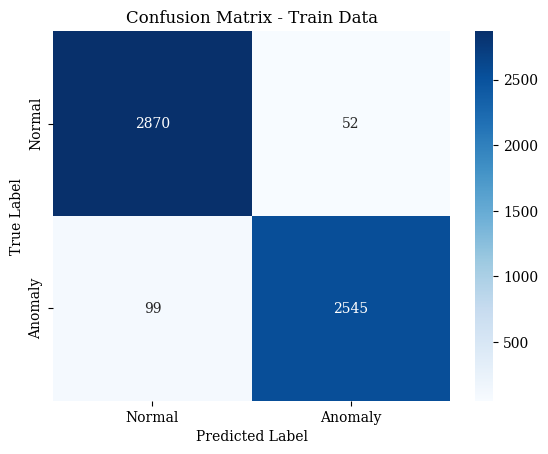


Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.9822    0.9744      2922
           1     0.9800    0.9626    0.9712      2644

    accuracy                         0.9729      5566
   macro avg     0.9733    0.9724    0.9728      5566
weighted avg     0.9730    0.9729    0.9729      5566


Test Data Evaluation:


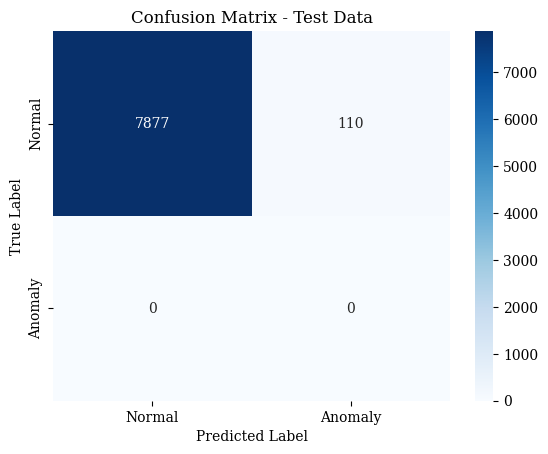


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9862      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9862    0.9931      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


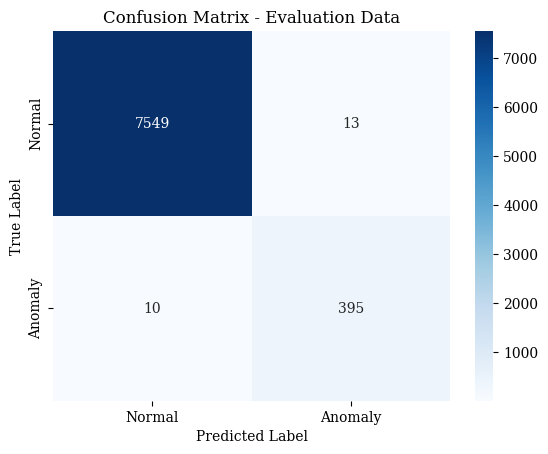


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9983    0.9985      7562
           1     0.9681    0.9753    0.9717       405

    accuracy                         0.9971      7967
   macro avg     0.9834    0.9868    0.9851      7967
weighted avg     0.9971    0.9971    0.9971      7967



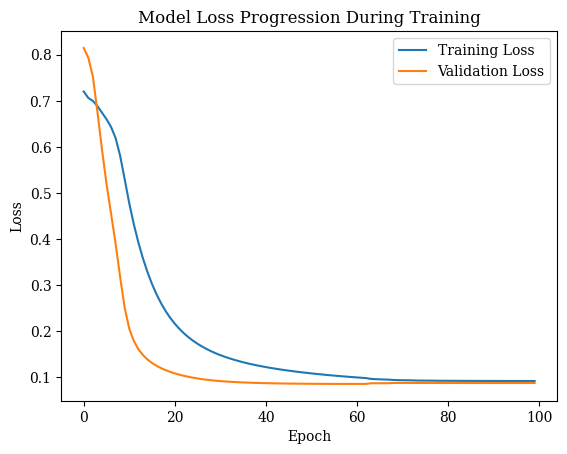

In [23]:
# ===================== #
# 📌 Reproducible Setup #
# ===================== #

import os
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# ======================== #
# 📚 Import Other Packages #
# ======================== #

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ================= #
# 📂 Load Datasets  #
# ================= #

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')

# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())

# ================ #
# 🔍 Preprocessing #
# ================ #

scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl = scaler.transform(eval_df.drop(columns=['label']))

# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values

# ========================== #
# 🔧 Feature Reduction Model #
# ========================== #

class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()
        self.batch_norm = BatchNormalization()
        self.dense_1 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dropout_2 = Dropout(0.3)
        self.latent_layer = Dense(latent_dim, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_3 = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.dense_4 = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))

    def call(self, inputs):
        x = self.batch_norm(inputs)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)
        return reconstruction

def build_encoder(input_dim, latent_dim):
    encoder = FeatureReductionEncoder(input_dim, latent_dim)
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return encoder

input_dim = X_train.shape[1]
latent_dim = 6
encoder = build_encoder(input_dim, latent_dim)

encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")

# =========================== #
# 🔁 GRU-Based Multi-Task Model #
# =========================== #

def build_multi_task_gru(input_dim):
    inputs = Input(shape=(input_dim, 1))
    gru_out1 = GRU(8, return_sequences=True)(inputs)
    gru_out2 = GRU(16, return_sequences=False)(gru_out1)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model

# Reshape for GRU input
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()

history = multi_task_gru_model.fit(
    X_train_latent_seq,
    {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# ============ #
# 🔍 Evaluation #
# ============ #

y_pred_train_anomaly, _ = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, _ = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, _ = multi_task_gru_model.predict(X_eval_latent_seq)

y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# ==================== #
# 📈 Loss Visualization #
# ==================== #

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Batch Size

## Proposed EEMTL Model (64)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_30 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_31 (GRU)        │ (None, 32)        │      9,408 │ gru_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_31[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_31[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - anomaly_output_accuracy: 0.5562 - anomaly_output_loss: 0.6891 - future_output_loss: 0.0270 - loss: 0.7161 - val_anomaly_output_accuracy: 0.8474 - val_anomaly_output_loss: 0.6336 - val_future_output_loss: 0.0614 - val_loss: 0.6955 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5939 - anomaly_output_loss: 0.6665 - future_output_loss: 0.0146 - loss: 0.6812 - val_anomaly_output_accuracy: 0.9255 - val_anomaly_output_loss: 0.4394 - val_future_output_loss: 0.0545 - val_loss: 0.5016 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.6075 - anomaly_output_loss: 0.6435 - future_output_loss: 0.0108 - loss: 0.6543 - val_anomaly_output_accuracy: 0.9506 - val_anomaly_output_loss: 0.3704 - val_future_output_loss: 0.0447 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_outpu

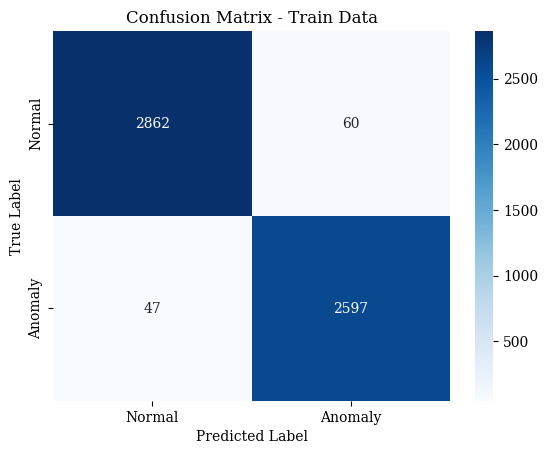


Classification Report:
              precision    recall  f1-score   support

           0     0.9838    0.9795    0.9816      2922
           1     0.9774    0.9822    0.9798      2644

    accuracy                         0.9808      5566
   macro avg     0.9806    0.9808    0.9807      5566
weighted avg     0.9808    0.9808    0.9808      5566


Test Data Evaluation:


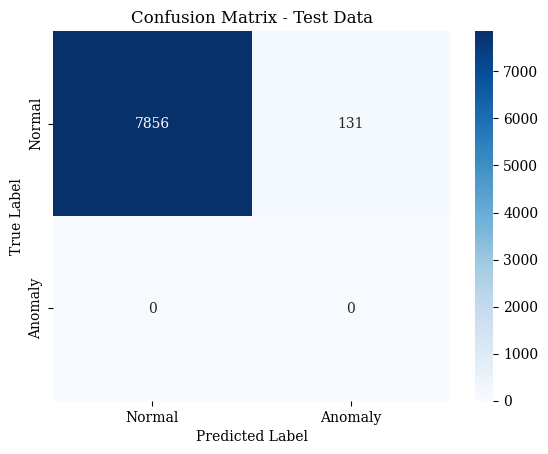


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9836    0.9917      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9836      7987
   macro avg     0.5000    0.4918    0.4959      7987
weighted avg     1.0000    0.9836    0.9917      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


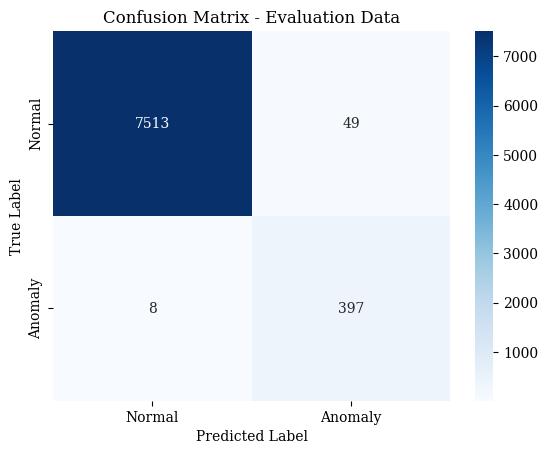


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9935    0.9962      7562
           1     0.8901    0.9802    0.9330       405

    accuracy                         0.9928      7967
   macro avg     0.9445    0.9869    0.9646      7967
weighted avg     0.9934    0.9928    0.9930      7967



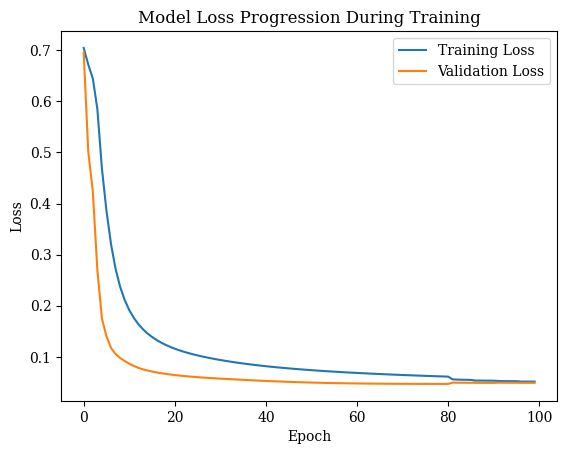

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (32)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3840 - val_loss: 1.0427
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2738 - val_loss: 1.0121
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2672 - val_loss: 1.0134
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2663 - val_loss: 1.0028
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2632 - val_loss: 0.9981
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2628 - val_loss: 0.9930
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2621 - val_loss: 0.9883
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2611 - val_loss: 0.9847
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_32 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_33 (GRU)        │ (None, 32)        │      9,408 │ gru_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_33[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_33[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - anomaly_output_accuracy: 0.5633 - anomaly_output_loss: 0.6849 - future_output_loss: 0.0233 - loss: 0.7082 - val_anomaly_output_accuracy: 0.9120 - val_anomaly_output_loss: 0.4941 - val_future_output_loss: 0.0462 - val_loss: 0.5415 - learning_rate: 5.0000e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.6135 - anomaly_output_loss: 0.6453 - future_output_loss: 0.0105 - loss: 0.6557 - val_anomaly_output_accuracy: 0.9578 - val_anomaly_output_loss: 0.3169 - val_future_output_loss: 0.0358 - val_loss: 0.3540 - learning_rate: 5.0000e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - anomaly_output_accuracy: 0.7677 - anomaly_output_loss: 0.5272 - future_output_loss: 0.0089 - loss: 0.5361 - val_anomaly_output_accuracy: 0.9668 - val_anomaly_output_loss: 0.1232 - val_future_output_loss: 0.0289 - val_loss: 0.1526 - learning_rate: 5.0000e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anoma

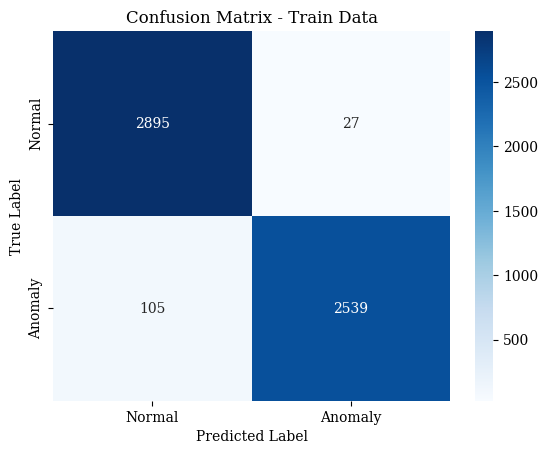


Classification Report:
              precision    recall  f1-score   support

           0     0.9650    0.9908    0.9777      2922
           1     0.9895    0.9603    0.9747      2644

    accuracy                         0.9763      5566
   macro avg     0.9772    0.9755    0.9762      5566
weighted avg     0.9766    0.9763    0.9763      5566


Test Data Evaluation:


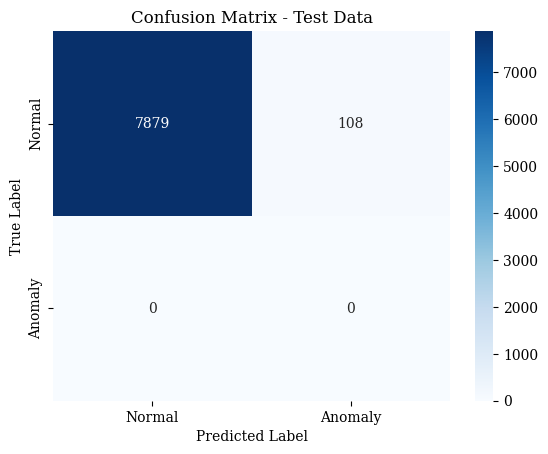


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9865    0.9932      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9865      7987
   macro avg     0.5000    0.4932    0.4966      7987
weighted avg     1.0000    0.9865    0.9932      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


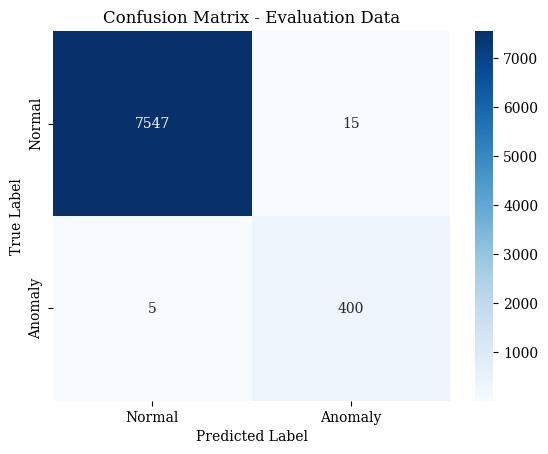


Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9980    0.9987      7562
           1     0.9639    0.9877    0.9756       405

    accuracy                         0.9975      7967
   macro avg     0.9816    0.9928    0.9871      7967
weighted avg     0.9975    0.9975    0.9975      7967



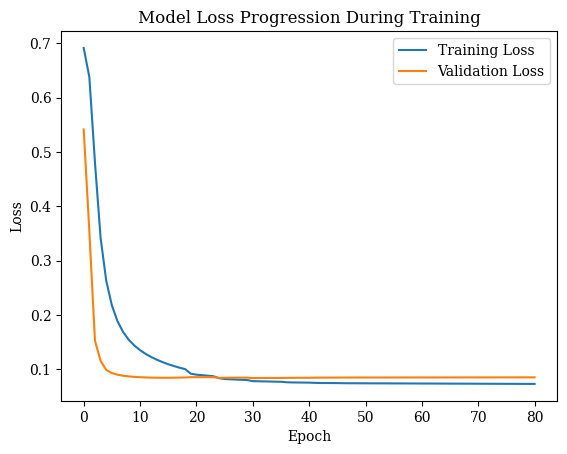

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=32,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (128)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4450 - val_loss: 1.1434
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3212 - val_loss: 1.0509
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2788 - val_loss: 1.0345
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2728 - val_loss: 1.0258
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2702 - val_loss: 1.0179
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2686 - val_loss: 1.0119
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2673 - val_loss: 1.0086
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2665 - val_loss: 1.0027
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2655 

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_34 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_35 (GRU)        │ (None, 32)        │      9,408 │ gru_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_35[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_35[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - anomaly_output_accuracy: 0.5549 - anomaly_output_loss: 0.6913 - future_output_loss: 0.0310 - loss: 0.7223 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7059 - val_future_output_loss: 0.0670 - val_loss: 0.7693 - learning_rate: 5.0000e-04
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - anomaly_output_accuracy: 0.5645 - anomaly_output_loss: 0.6805 - future_output_loss: 0.0169 - loss: 0.6973 - val_anomaly_output_accuracy: 0.8223 - val_anomaly_output_loss: 0.6143 - val_future_output_loss: 0.0564 - val_loss: 0.6694 - learning_rate: 5.0000e-04
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - anomaly_output_accuracy: 0.5923 - anomaly_output_loss: 0.6668 - future_output_loss: 0.0135 - loss: 0.6803 - val_anomaly_output_accuracy: 0.8716 - val_anomaly_output_loss: 0.4932 - val_future_output_loss: 0.0559 - val_loss: 0.5505 - learning_rate: 5.0000e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - anomaly_ou

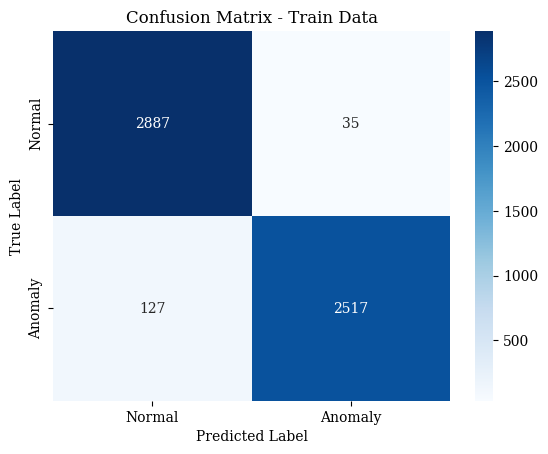


Classification Report:
              precision    recall  f1-score   support

           0     0.9579    0.9880    0.9727      2922
           1     0.9863    0.9520    0.9688      2644

    accuracy                         0.9709      5566
   macro avg     0.9721    0.9700    0.9708      5566
weighted avg     0.9714    0.9709    0.9709      5566


Test Data Evaluation:


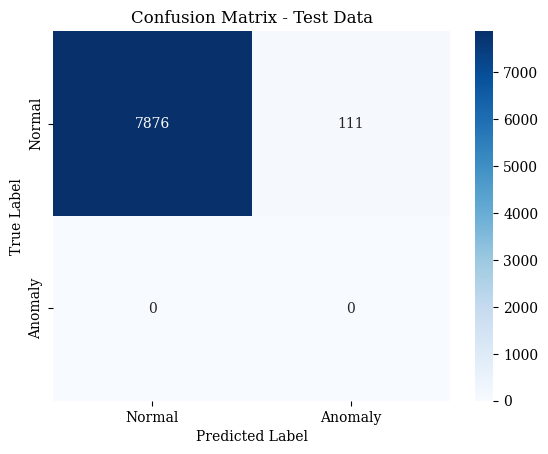


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9861    0.9930      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9861      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9861    0.9930      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


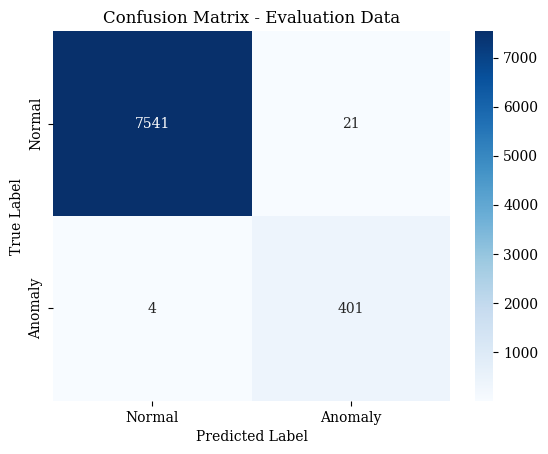


Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9972    0.9983      7562
           1     0.9502    0.9901    0.9698       405

    accuracy                         0.9969      7967
   macro avg     0.9749    0.9937    0.9841      7967
weighted avg     0.9970    0.9969    0.9969      7967



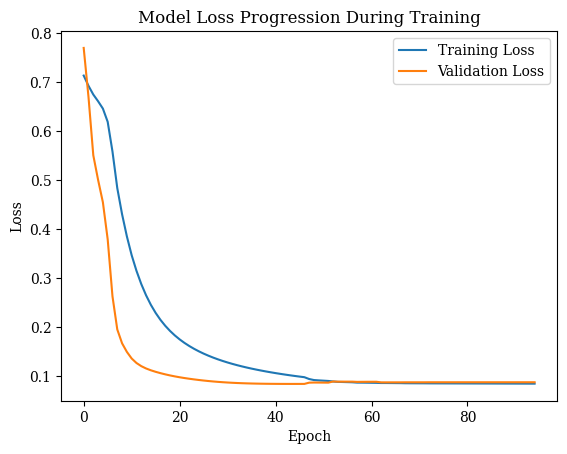

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=128,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (256)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4612 - val_loss: 1.2000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4212 - val_loss: 1.1224
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3285 - val_loss: 1.0702
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2894 - val_loss: 1.0440
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2844 - val_loss: 1.0397
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2814 - val_loss: 1.0334
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2793 - val_loss: 1.0306
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2780 - val_loss: 1.0252
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2767

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_36 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_37 (GRU)        │ (None, 32)        │      9,408 │ gru_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_37[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_37[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - anomaly_output_accuracy: 0.5541 - anomaly_output_loss: 0.6927 - future_output_loss: 0.0336 - loss: 0.7264 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7120 - val_future_output_loss: 0.0938 - val_loss: 0.7922 - learning_rate: 5.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - anomaly_output_accuracy: 0.5541 - anomaly_output_loss: 0.6860 - future_output_loss: 0.0195 - loss: 0.7056 - val_anomaly_output_accuracy: 0.3842 - val_anomaly_output_loss: 0.7017 - val_future_output_loss: 0.0635 - val_loss: 0.7529 - learning_rate: 5.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - anomaly_output_accuracy: 0.5646 - anomaly_output_loss: 0.6800 - future_output_loss: 0.0167 - loss: 0.6967 - val_anomaly_output_accuracy: 0.7415 - val_anomaly_output_loss: 0.6454 - val_future_output_loss: 0.0602 - val_loss: 0.6993 - learning_rate: 5.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - anomaly_ou

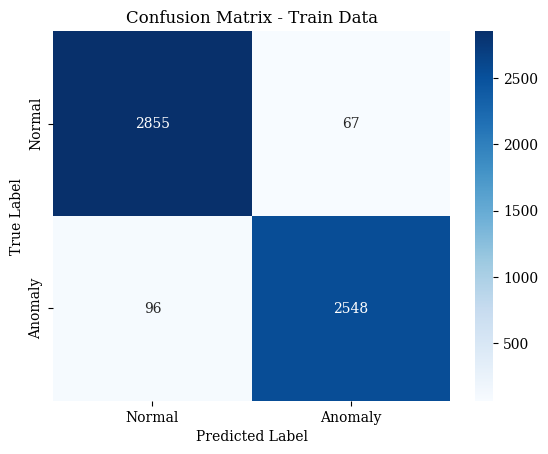


Classification Report:
              precision    recall  f1-score   support

           0     0.9675    0.9771    0.9722      2922
           1     0.9744    0.9637    0.9690      2644

    accuracy                         0.9707      5566
   macro avg     0.9709    0.9704    0.9706      5566
weighted avg     0.9708    0.9707    0.9707      5566


Test Data Evaluation:


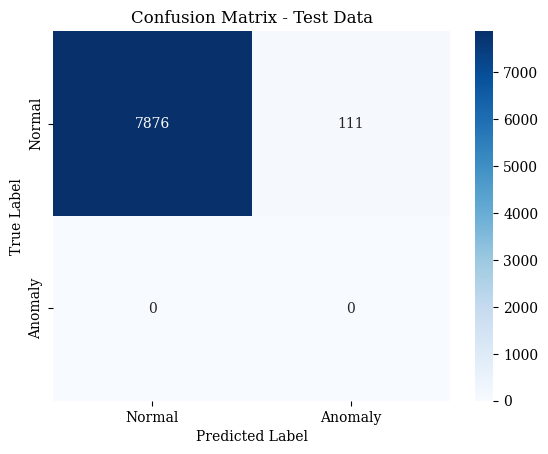


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9861    0.9930      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9861      7987
   macro avg     0.5000    0.4931    0.4965      7987
weighted avg     1.0000    0.9861    0.9930      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


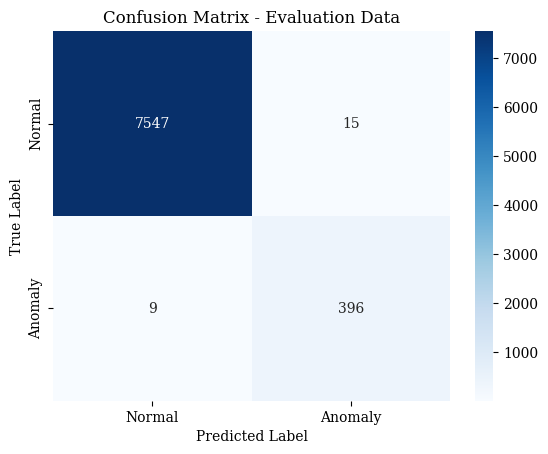


Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9980    0.9984      7562
           1     0.9635    0.9778    0.9706       405

    accuracy                         0.9970      7967
   macro avg     0.9812    0.9879    0.9845      7967
weighted avg     0.9970    0.9970    0.9970      7967



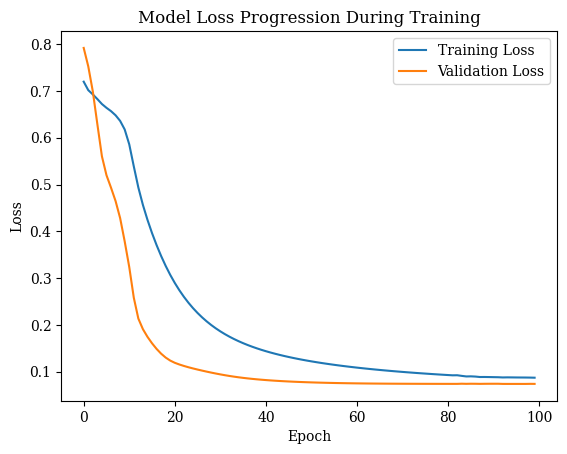

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=256, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=256,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Learning Rate

## Proposed EEMTL Model (0.1)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_38 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_39 (GRU)        │ (None, 32)        │      9,408 │ gru_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_39[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_39[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - anomaly_output_accuracy: 0.5242 - anomaly_output_loss: 0.8218 - future_output_loss: 0.6018 - loss: 1.4236 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.8881 - val_future_output_loss: 0.1088 - val_loss: 0.9831 - learning_rate: 0.1000
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5259 - anomaly_output_loss: 0.7354 - future_output_loss: 0.0271 - loss: 0.7625 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.8778 - val_future_output_loss: 0.0946 - val_loss: 0.9595 - learning_rate: 0.1000
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5286 - anomaly_output_loss: 0.7310 - future_output_loss: 0.0308 - loss: 0.7619 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.8268 - val_future_output_loss: 0.0776 - val_loss: 0.8924 - learning_rate: 0.1000
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 

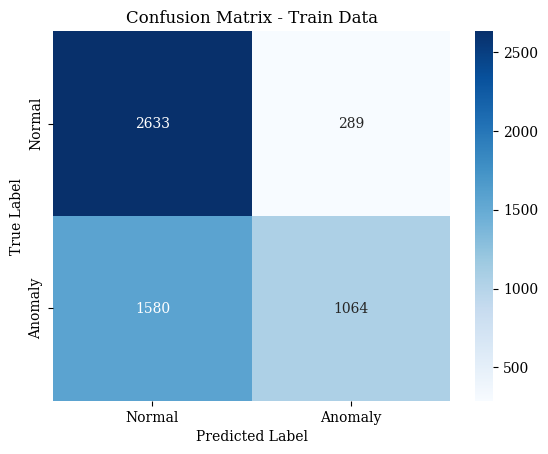


Classification Report:
              precision    recall  f1-score   support

           0     0.6250    0.9011    0.7381      2922
           1     0.7864    0.4024    0.5324      2644

    accuracy                         0.6642      5566
   macro avg     0.7057    0.6518    0.6352      5566
weighted avg     0.7017    0.6642    0.6404      5566


Test Data Evaluation:


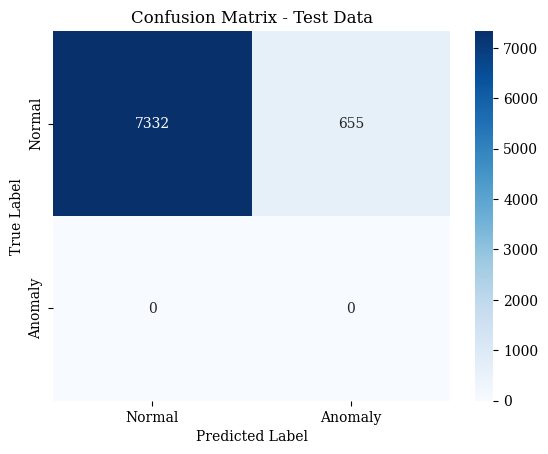


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9180    0.9572      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9180      7987
   macro avg     0.5000    0.4590    0.4786      7987
weighted avg     1.0000    0.9180    0.9572      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


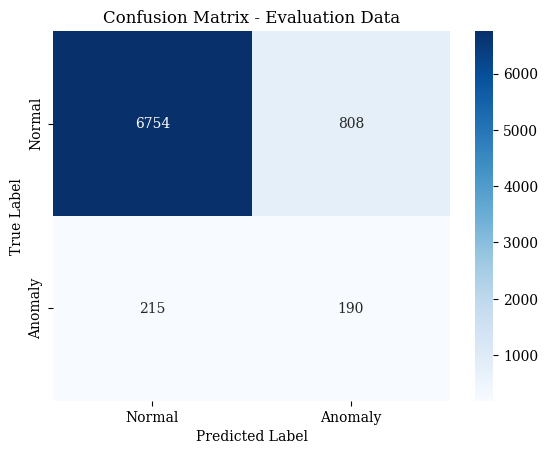


Classification Report:
              precision    recall  f1-score   support

           0     0.9691    0.8931    0.9296      7562
           1     0.1904    0.4691    0.2708       405

    accuracy                         0.8716      7967
   macro avg     0.5798    0.6811    0.6002      7967
weighted avg     0.9296    0.8716    0.8961      7967



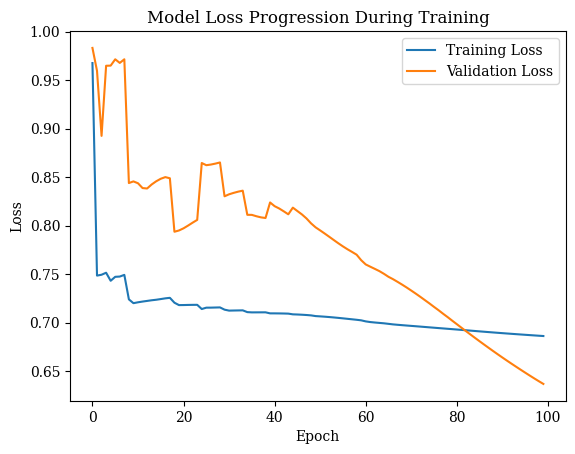

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.1),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.01)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_40 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_41 (GRU)        │ (None, 32)        │      9,408 │ gru_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_41[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_41[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.6762 - anomaly_output_loss: 0.5940 - future_output_loss: 0.0184 - loss: 0.6125 - val_anomaly_output_accuracy: 0.9749 - val_anomaly_output_loss: 0.0589 - val_future_output_loss: 0.0481 - val_loss: 0.1077 - learning_rate: 0.0100
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 0.9290 - anomaly_output_loss: 0.1664 - future_output_loss: 0.0112 - loss: 0.1776 - val_anomaly_output_accuracy: 0.9776 - val_anomaly_output_loss: 0.0476 - val_future_output_loss: 0.0189 - val_loss: 0.0679 - learning_rate: 0.0100
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.9122 - anomaly_output_loss: 0.1801 - future_output_loss: 0.0064 - loss: 0.1864 - val_anomaly_output_accuracy: 0.9838 - val_anomaly_output_loss: 0.0412 - val_future_output_loss: 0.0164 - val_loss: 0.0587 - learning_rate: 0.0100
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 

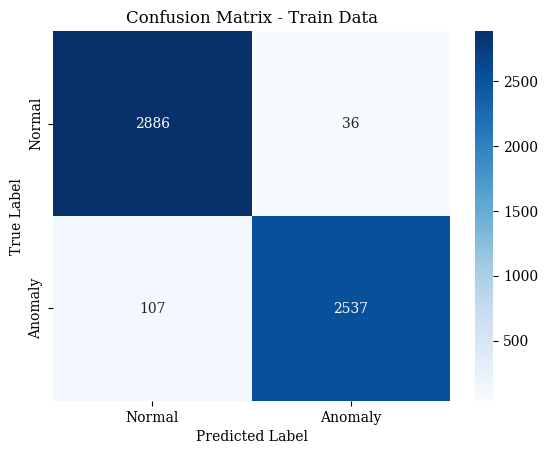


Classification Report:
              precision    recall  f1-score   support

           0     0.9642    0.9877    0.9758      2922
           1     0.9860    0.9595    0.9726      2644

    accuracy                         0.9743      5566
   macro avg     0.9751    0.9736    0.9742      5566
weighted avg     0.9746    0.9743    0.9743      5566


Test Data Evaluation:


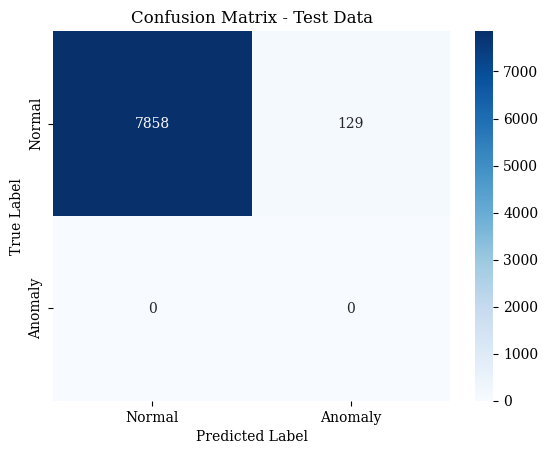


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9838    0.9919      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9838      7987
   macro avg     0.5000    0.4919    0.4959      7987
weighted avg     1.0000    0.9838    0.9919      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


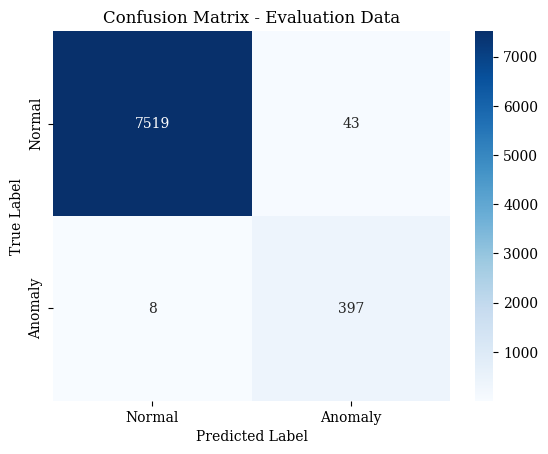


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9943    0.9966      7562
           1     0.9023    0.9802    0.9396       405

    accuracy                         0.9936      7967
   macro avg     0.9506    0.9873    0.9681      7967
weighted avg     0.9940    0.9936    0.9937      7967



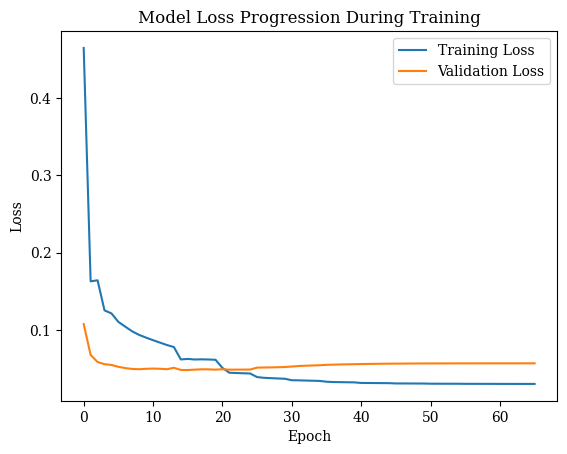

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.05)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_42 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_43 (GRU)        │ (None, 32)        │      9,408 │ gru_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_43[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_43[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.5842 - anomaly_output_loss: 0.6789 - future_output_loss: 0.1061 - loss: 0.7850 - val_anomaly_output_accuracy: 0.9749 - val_anomaly_output_loss: 0.0459 - val_future_output_loss: 0.0413 - val_loss: 0.0890 - learning_rate: 0.0500
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.9085 - anomaly_output_loss: 0.2062 - future_output_loss: 0.0113 - loss: 0.2175 - val_anomaly_output_accuracy: 0.9758 - val_anomaly_output_loss: 0.0474 - val_future_output_loss: 0.0180 - val_loss: 0.0665 - learning_rate: 0.0500
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.9373 - anomaly_output_loss: 0.1288 - future_output_loss: 0.0059 - loss: 0.1347 - val_anomaly_output_accuracy: 0.9785 - val_anomaly_output_loss: 0.0511 - val_future_output_loss: 0.0164 - val_loss: 0.0687 - learning_rate: 0.0500
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - anomaly_output_accuracy: 

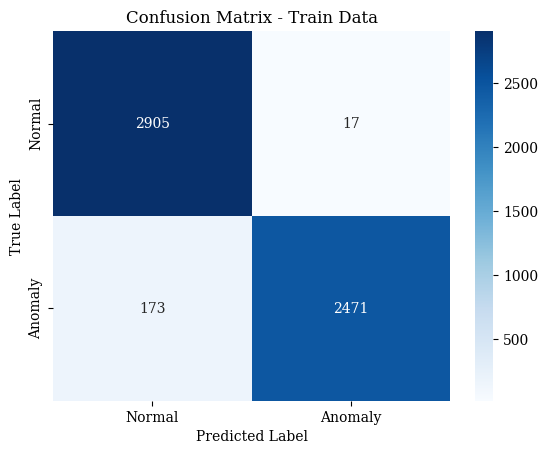


Classification Report:
              precision    recall  f1-score   support

           0     0.9438    0.9942    0.9683      2922
           1     0.9932    0.9346    0.9630      2644

    accuracy                         0.9659      5566
   macro avg     0.9685    0.9644    0.9657      5566
weighted avg     0.9672    0.9659    0.9658      5566


Test Data Evaluation:


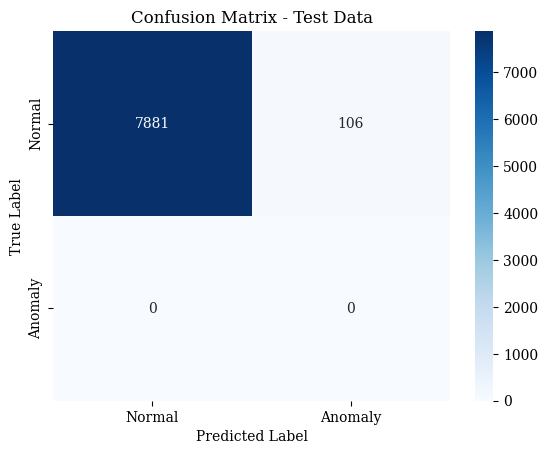


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9867    0.9933      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9867      7987
   macro avg     0.5000    0.4934    0.4967      7987
weighted avg     1.0000    0.9867    0.9933      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


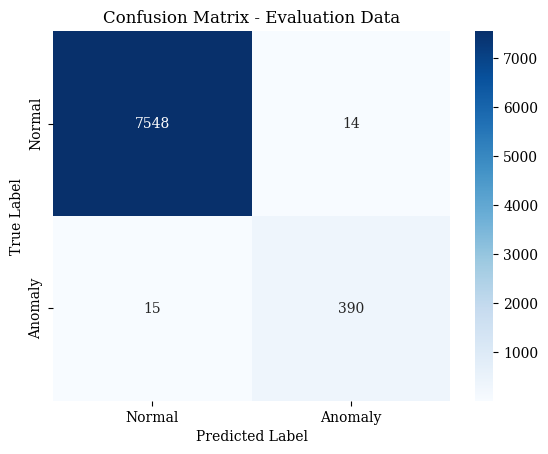


Classification Report:
              precision    recall  f1-score   support

           0     0.9980    0.9981    0.9981      7562
           1     0.9653    0.9630    0.9642       405

    accuracy                         0.9964      7967
   macro avg     0.9817    0.9806    0.9811      7967
weighted avg     0.9964    0.9964    0.9964      7967



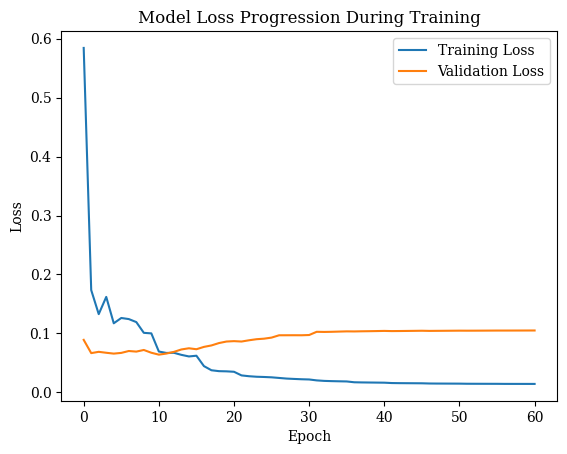

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.05),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.001)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_44 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_45 (GRU)        │ (None, 32)        │      9,408 │ gru_44[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_45[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_45[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - anomaly_output_accuracy: 0.5629 - anomaly_output_loss: 0.6845 - future_output_loss: 0.0233 - loss: 0.7078 - val_anomaly_output_accuracy: 0.9147 - val_anomaly_output_loss: 0.4580 - val_future_output_loss: 0.0558 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.6167 - anomaly_output_loss: 0.6416 - future_output_loss: 0.0114 - loss: 0.6530 - val_anomaly_output_accuracy: 0.9560 - val_anomaly_output_loss: 0.2994 - val_future_output_loss: 0.0406 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.7703 - anomaly_output_loss: 0.5212 - future_output_loss: 0.0092 - loss: 0.5304 - val_anomaly_output_accuracy: 0.9641 - val_anomaly_output_loss: 0.1082 - val_future_output_loss: 0.0304 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 

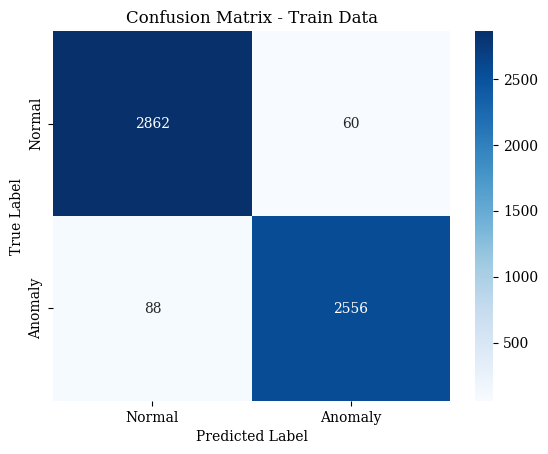


Classification Report:
              precision    recall  f1-score   support

           0     0.9702    0.9795    0.9748      2922
           1     0.9771    0.9667    0.9719      2644

    accuracy                         0.9734      5566
   macro avg     0.9736    0.9731    0.9733      5566
weighted avg     0.9734    0.9734    0.9734      5566


Test Data Evaluation:


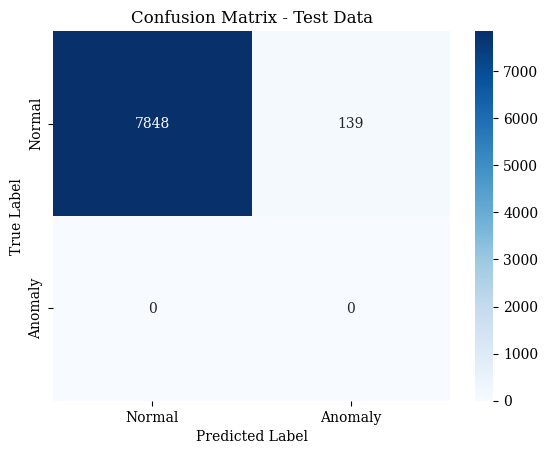


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9826    0.9912      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9826      7987
   macro avg     0.5000    0.4913    0.4956      7987
weighted avg     1.0000    0.9826    0.9912      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


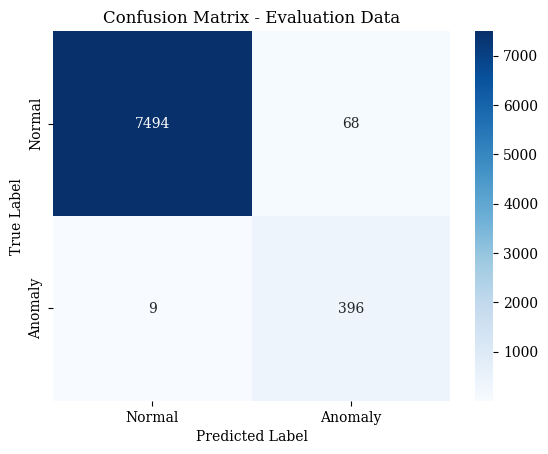


Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9910    0.9949      7562
           1     0.8534    0.9778    0.9114       405

    accuracy                         0.9903      7967
   macro avg     0.9261    0.9844    0.9531      7967
weighted avg     0.9914    0.9903    0.9906      7967



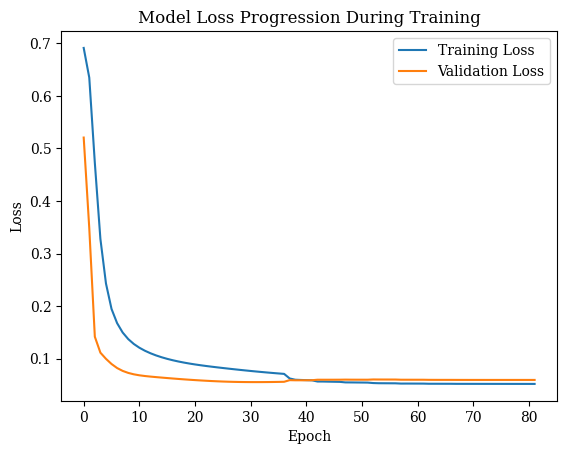

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.005)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_46 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_47 (GRU)        │ (None, 32)        │      9,408 │ gru_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_47[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_47[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - anomaly_output_accuracy: 0.6274 - anomaly_output_loss: 0.6384 - future_output_loss: 0.0175 - loss: 0.6559 - val_anomaly_output_accuracy: 0.9695 - val_anomaly_output_loss: 0.0666 - val_future_output_loss: 0.0509 - val_loss: 0.1183 - learning_rate: 0.0050
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.9045 - anomaly_output_loss: 0.2306 - future_output_loss: 0.0137 - loss: 0.2443 - val_anomaly_output_accuracy: 0.9803 - val_anomaly_output_loss: 0.0441 - val_future_output_loss: 0.0288 - val_loss: 0.0733 - learning_rate: 0.0050
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - anomaly_output_accuracy: 0.9460 - anomaly_output_loss: 0.1393 - future_output_loss: 0.0071 - loss: 0.1463 - val_anomaly_output_accuracy: 0.9811 - val_anomaly_output_loss: 0.0427 - val_future_output_loss: 0.0212 - val_loss: 0.0647 - learning_rate: 0.0050
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - anomaly_output_accuracy

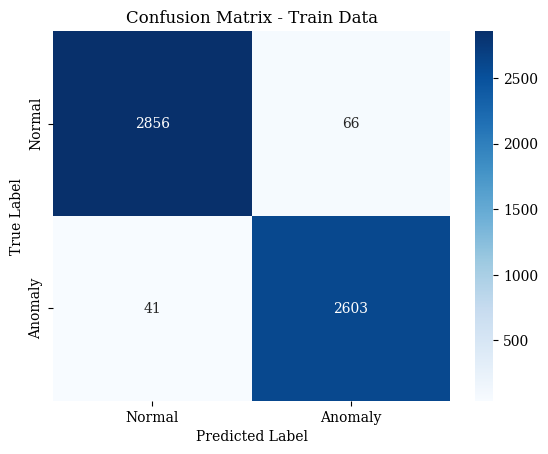


Classification Report:
              precision    recall  f1-score   support

           0     0.9858    0.9774    0.9816      2922
           1     0.9753    0.9845    0.9799      2644

    accuracy                         0.9808      5566
   macro avg     0.9806    0.9810    0.9807      5566
weighted avg     0.9808    0.9808    0.9808      5566


Test Data Evaluation:


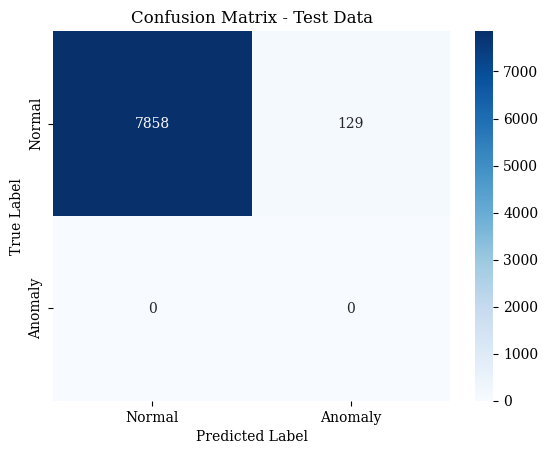


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9838    0.9919      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9838      7987
   macro avg     0.5000    0.4919    0.4959      7987
weighted avg     1.0000    0.9838    0.9919      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


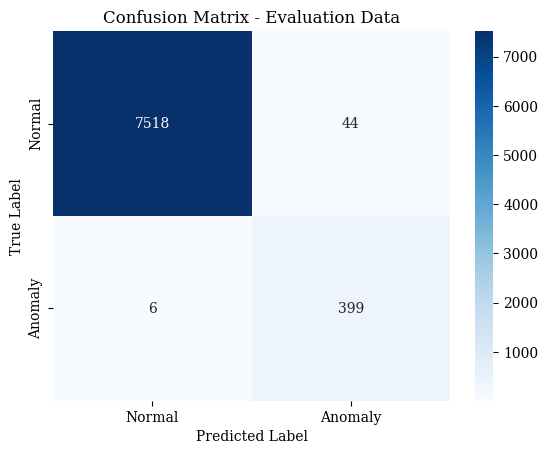


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9942    0.9967      7562
           1     0.9007    0.9852    0.9410       405

    accuracy                         0.9937      7967
   macro avg     0.9499    0.9897    0.9689      7967
weighted avg     0.9942    0.9937    0.9939      7967



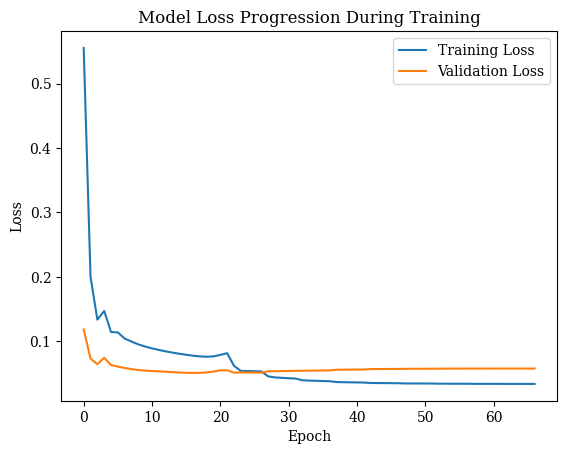

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.0001)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_48 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_49 (GRU)        │ (None, 32)        │      9,408 │ gru_48[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_49[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_49[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6932 - future_output_loss: 0.0359 - loss: 0.7290 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7098 - val_future_output_loss: 0.1103 - val_loss: 0.8159 - learning_rate: 1.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6888 - future_output_loss: 0.0234 - loss: 0.7122 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7069 - val_future_output_loss: 0.0782 - val_loss: 0.7818 - learning_rate: 1.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.5559 - anomaly_output_loss: 0.6845 - future_output_loss: 0.0186 - loss: 0.7032 - val_anomaly_output_accuracy: 0.4165 - val_anomaly_output_loss: 0.6873 - val_future_output_loss: 0.0680 - val_loss: 0.7531 - learning_rate: 1.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_outpu

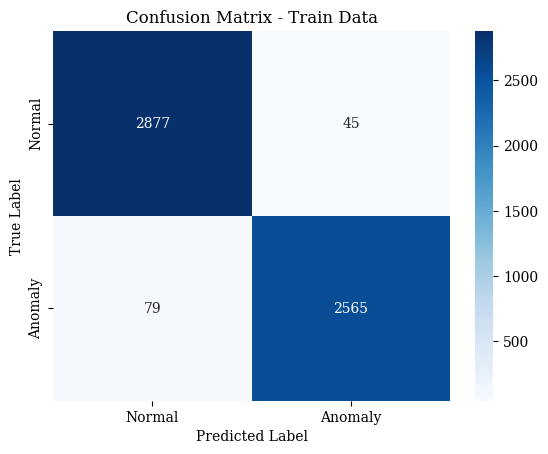


Classification Report:
              precision    recall  f1-score   support

           0     0.9733    0.9846    0.9789      2922
           1     0.9828    0.9701    0.9764      2644

    accuracy                         0.9777      5566
   macro avg     0.9780    0.9774    0.9777      5566
weighted avg     0.9778    0.9777    0.9777      5566


Test Data Evaluation:


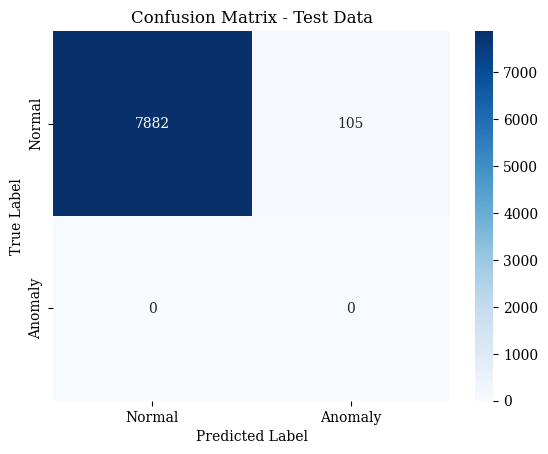


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9869    0.9934      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9869      7987
   macro avg     0.5000    0.4934    0.4967      7987
weighted avg     1.0000    0.9869    0.9934      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


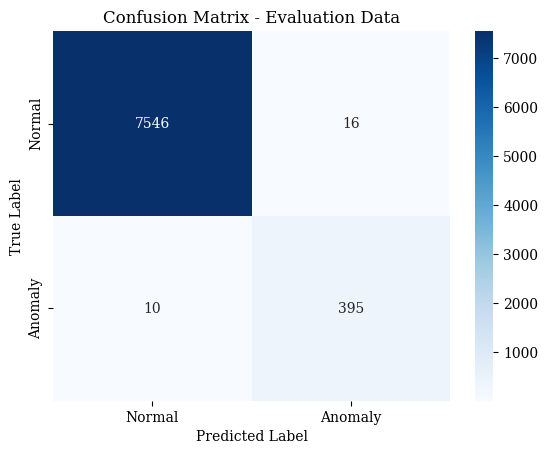


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9979    0.9983      7562
           1     0.9611    0.9753    0.9681       405

    accuracy                         0.9967      7967
   macro avg     0.9799    0.9866    0.9832      7967
weighted avg     0.9968    0.9967    0.9967      7967



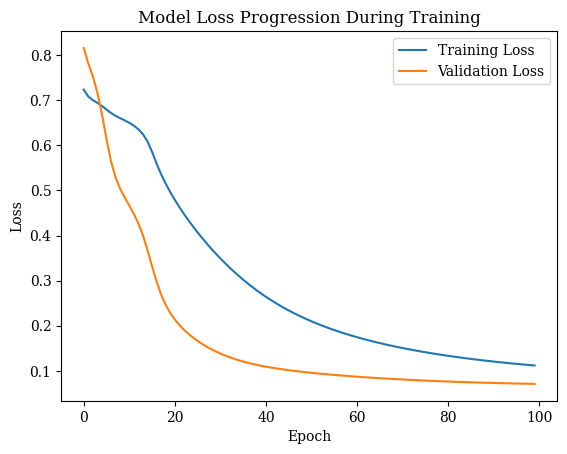

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.0005)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_50 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_51 (GRU)        │ (None, 32)        │      9,408 │ gru_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_51[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_51[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - anomaly_output_accuracy: 0.5562 - anomaly_output_loss: 0.6891 - future_output_loss: 0.0270 - loss: 0.7161 - val_anomaly_output_accuracy: 0.8474 - val_anomaly_output_loss: 0.6336 - val_future_output_loss: 0.0614 - val_loss: 0.6955 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.5939 - anomaly_output_loss: 0.6665 - future_output_loss: 0.0146 - loss: 0.6812 - val_anomaly_output_accuracy: 0.9255 - val_anomaly_output_loss: 0.4394 - val_future_output_loss: 0.0545 - val_loss: 0.5016 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.6075 - anomaly_output_loss: 0.6435 - future_output_loss: 0.0108 - loss: 0.6543 - val_anomaly_output_accuracy: 0.9506 - val_anomaly_output_loss: 0.3704 - val_future_output_loss: 0.0447 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_outpu

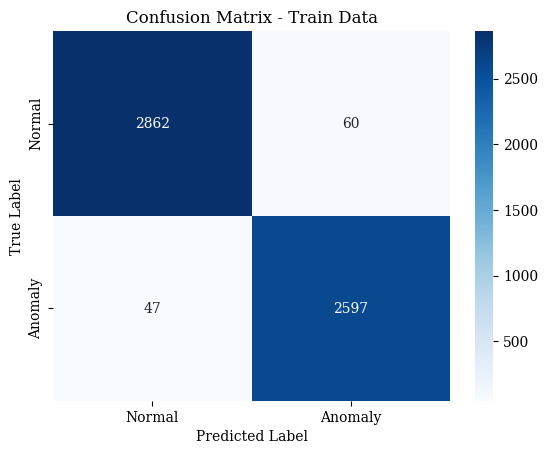


Classification Report:
              precision    recall  f1-score   support

           0     0.9838    0.9795    0.9816      2922
           1     0.9774    0.9822    0.9798      2644

    accuracy                         0.9808      5566
   macro avg     0.9806    0.9808    0.9807      5566
weighted avg     0.9808    0.9808    0.9808      5566


Test Data Evaluation:


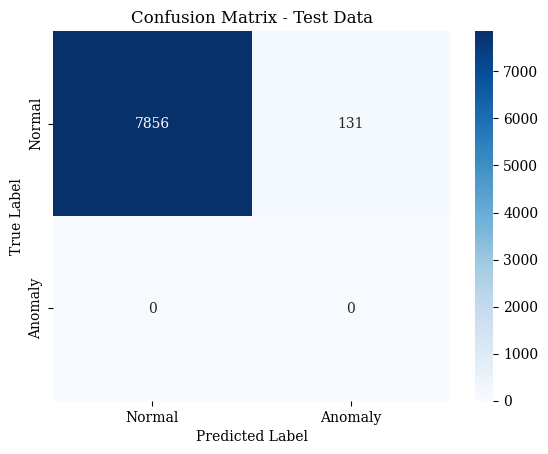


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9836    0.9917      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9836      7987
   macro avg     0.5000    0.4918    0.4959      7987
weighted avg     1.0000    0.9836    0.9917      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


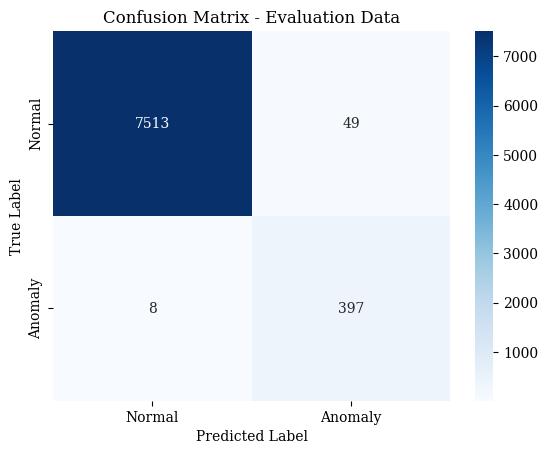


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9935    0.9962      7562
           1     0.8901    0.9802    0.9330       405

    accuracy                         0.9928      7967
   macro avg     0.9445    0.9869    0.9646      7967
weighted avg     0.9934    0.9928    0.9930      7967



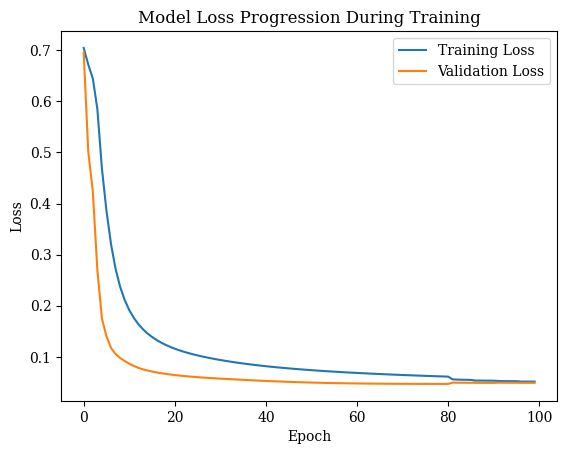

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.00001)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_52 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_53 (GRU)        │ (None, 32)        │      9,408 │ gru_52[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_53[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_53[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6941 - future_output_loss: 0.0396 - loss: 0.7336 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7095 - val_future_output_loss: 0.1532 - val_loss: 0.8574 - learning_rate: 1.0000e-05
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6937 - future_output_loss: 0.0379 - loss: 0.7315 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7094 - val_future_output_loss: 0.1480 - val_loss: 0.8523 - learning_rate: 1.0000e-05
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6932 - future_output_loss: 0.0362 - loss: 0.7295 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7093 - val_future_output_loss: 0.1430 - val_loss: 0.8472 - learning_rate: 1.0000e-05
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_outpu

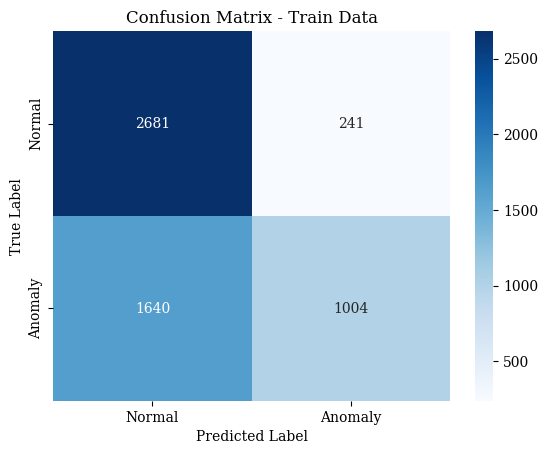


Classification Report:
              precision    recall  f1-score   support

           0     0.6205    0.9175    0.7403      2922
           1     0.8064    0.3797    0.5163      2644

    accuracy                         0.6621      5566
   macro avg     0.7134    0.6486    0.6283      5566
weighted avg     0.7088    0.6621    0.6339      5566


Test Data Evaluation:


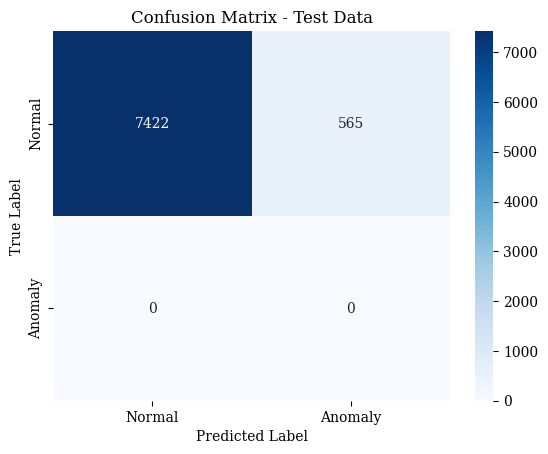


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9293    0.9633      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9293      7987
   macro avg     0.5000    0.4646    0.4817      7987
weighted avg     1.0000    0.9293    0.9633      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


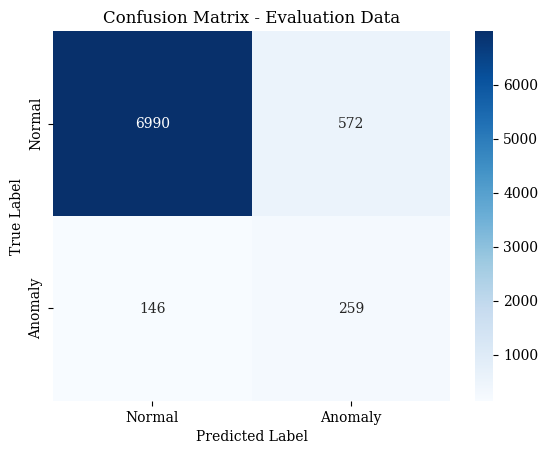


Classification Report:
              precision    recall  f1-score   support

           0     0.9795    0.9244    0.9511      7562
           1     0.3117    0.6395    0.4191       405

    accuracy                         0.9099      7967
   macro avg     0.6456    0.7819    0.6851      7967
weighted avg     0.9456    0.9099    0.9241      7967



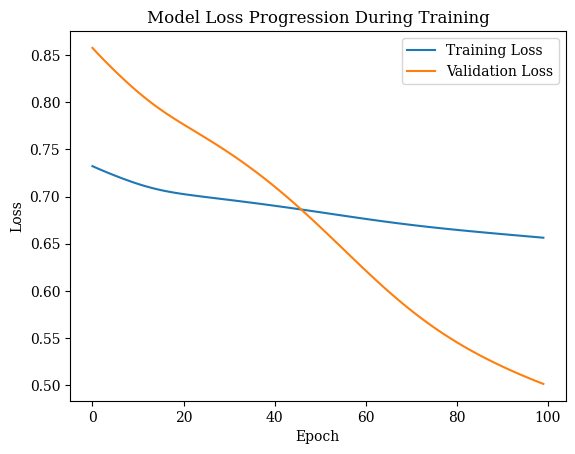

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Proposed EEMTL Model (0.00005)

Train dataset class distribution:
label
0    2922
1    2644
Name: count, dtype: int64

Test dataset class distribution:
label
0    7987
Name: count, dtype: int64

Evaluation dataset class distribution:
label
0    7562
1     405
Name: count, dtype: int64
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4179 - val_loss: 1.0659
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2798 - val_loss: 1.0243
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2700 - val_loss: 1.0074
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.9958
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.9871
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - val_loss: 0.9853
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2638 - val_loss: 0.9814
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.9834
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2619 

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_54 (GRU)        │ (None, 6, 64)     │     12,864 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_55 (GRU)        │ (None, 32)        │      9,408 │ gru_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anomaly_output      │ (None, 1)         │         33 │ gru_55[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_output       │ (None, 6)         │        198 │ gru_55[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,503 (87.90 KB)

 Trainable params: 22,503 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6937 - future_output_loss: 0.0378 - loss: 0.7315 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7094 - val_future_output_loss: 0.1331 - val_loss: 0.8377 - learning_rate: 5.0000e-05
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6915 - future_output_loss: 0.0303 - loss: 0.7218 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7094 - val_future_output_loss: 0.1103 - val_loss: 0.8155 - learning_rate: 5.0000e-05
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_output_accuracy: 0.5556 - anomaly_output_loss: 0.6893 - future_output_loss: 0.0243 - loss: 0.7136 - val_anomaly_output_accuracy: 0.3815 - val_anomaly_output_loss: 0.7089 - val_future_output_loss: 0.0911 - val_loss: 0.7964 - learning_rate: 5.0000e-05
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - anomaly_outpu

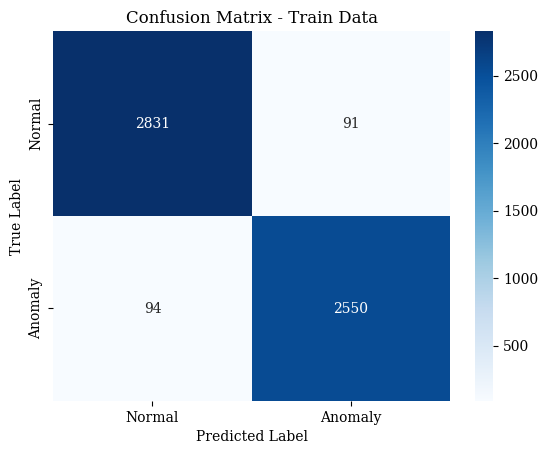


Classification Report:
              precision    recall  f1-score   support

           0     0.9679    0.9689    0.9684      2922
           1     0.9655    0.9644    0.9650      2644

    accuracy                         0.9668      5566
   macro avg     0.9667    0.9667    0.9667      5566
weighted avg     0.9668    0.9668    0.9668      5566


Test Data Evaluation:


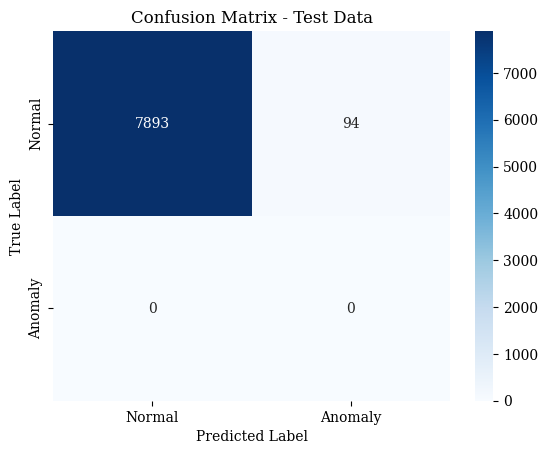


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9882    0.9941      7987
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9882      7987
   macro avg     0.5000    0.4941    0.4970      7987
weighted avg     1.0000    0.9882    0.9941      7987


Evaluation Data Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


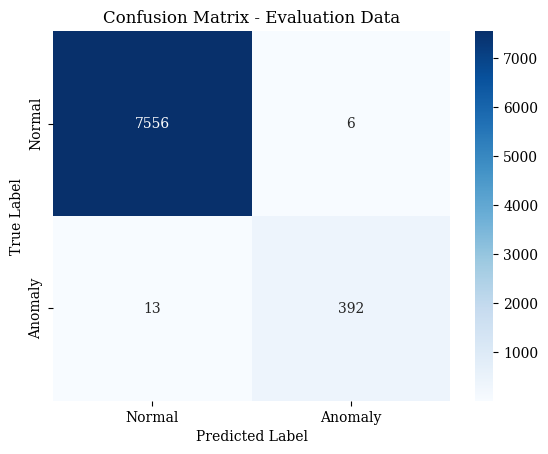


Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9992    0.9987      7562
           1     0.9849    0.9679    0.9763       405

    accuracy                         0.9976      7967
   macro avg     0.9916    0.9836    0.9875      7967
weighted avg     0.9976    0.9976    0.9976      7967



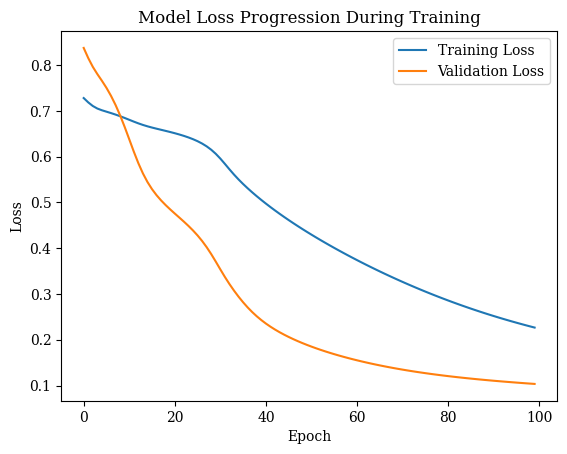

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
eval_df = pd.read_csv('eval.csv')


# Check distribution of classes
print("Train dataset class distribution:")
print(train_df['label'].value_counts())
print("\nTest dataset class distribution:")
print(test_df['label'].value_counts())
print("\nEvaluation dataset class distribution:")
print(eval_df['label'].value_counts())




scaler = StandardScaler()
X_traindl = scaler.fit_transform(train_df.drop(columns=['label']))
X_testdl = scaler.transform(test_df.drop(columns=['label']))
X_evaldl =scaler.transform(eval_df.drop(columns=['label']))


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_eval = eval_df.drop('label', axis=1).values
y_eval = eval_df['label'].values





from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Custom Encoder class for scaling and reducing features with dynamic latent dimension
class FeatureReductionEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(FeatureReductionEncoder, self).__init__()

        # Layers for feature scaling and reduction
        self.batch_norm = BatchNormalization()  # Normalization layer for scaling features
        self.dense_1 = Dense(128, activation="relu")  # Dense layer for feature reduction
        self.dropout_1 = Dropout(0.2)  # Dropout for regularization
        self.dense_2 = Dense(64, activation="relu")  # More reduction
        self.dropout_2 = Dropout(0.3)  # Dropout for regularization
        self.latent_layer = Dense(latent_dim, activation="tanh")  # Latent representation (dynamic)

        # Decoder part to reconstruct the input
        self.dense_3 = Dense(64, activation="relu")
        self.dense_4 = Dense(128, activation="relu")
        self.reconstruction_layer = Dense(input_dim, activation="sigmoid")  # Output layer for reconstruction

    def call(self, inputs):
        # Scale the features using BatchNormalization
        x = self.batch_norm(inputs)
        # Pass the scaled features through the dense layers
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        latent = self.latent_layer(x)  # Get the latent representation (dynamic size)

        # Decoder to reconstruct the input data from the latent space
        x = self.dense_3(latent)
        x = self.dense_4(x)
        reconstruction = self.reconstruction_layer(x)  # Reconstruct the input from the latent space

        return reconstruction  # Return the reconstructed input

# Function to build and compile the encoder model with dynamic latent dimension
def build_encoder(input_dim, latent_dim):
    # Instantiate the encoder with dynamic latent dimension
    encoder = FeatureReductionEncoder(input_dim, latent_dim)

    # Compile the encoder model with an optimizer and loss function
    encoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Mean Squared Error Loss

    return encoder

# Build and train the model with a dynamic latent dimension
input_dim = X_train.shape[1]  # Number of features in your dataset
latent_dim = 6  # Dynamically set the latent dimensionality (output features)

# Instantiate and train the encoder model
encoder = build_encoder(input_dim, latent_dim)

# Train the encoder model (using input as both the input and target for unsupervised learning)
encoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_split=0.2)

# After training, use the encoder to extract latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)
X_eval_latent = encoder.predict(X_eval)

# Output the shapes of the latent representations
print("Latent representation shapes:")
print(f"X_train_latent: {X_train_latent.shape}")
print(f"X_test_latent: {X_test_latent.shape}")
print(f"X_eval_latent: {X_eval_latent.shape}")





from tensorflow.keras.layers import Input, GRU, Dense, BatchNormalization, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_multi_task_gru(input_dim):
    """
    Build an advanced multi-task GRU-based model for anomaly detection and future prediction.
    """
    # Input layer
    inputs = Input(shape=(input_dim, 1))  # Reshape input for GRU layers

    # First GRU layer with return_sequences=True for stacking
    gru_out1 = GRU(64, return_sequences=True)(inputs)
    #pool_out1 = MaxPooling1D(pool_size=2)(gru_out1)
    # Second GRU layer with residual connection
    gru_out2 = GRU(32, return_sequences=False)(gru_out1)

    # First output: Anomaly detection (binary classification)
    anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(gru_out2)

    # Second output: Future prediction (reconstruction of original input)
    future_output = Dense(input_dim, activation='linear', name='future_output')(gru_out2)

    # Compile the model
    model = Model(inputs, [anomaly_output, future_output])
    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss={'anomaly_output': 'binary_crossentropy', 'future_output': 'mse'},
        metrics={'anomaly_output': 'accuracy'}
    )
    return model




# Reshape latent space for GRU model
X_train_latent_seq = np.reshape(X_train_latent, (X_train_latent.shape[0], X_train_latent.shape[1], 1))
X_test_latent_seq = np.reshape(X_test_latent, (X_test_latent.shape[0], X_test_latent.shape[1], 1))
X_eval_latent_seq = np.reshape(X_eval_latent, (X_eval_latent.shape[0], X_eval_latent.shape[1], 1))

# Learning rate scheduler and early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


# Build and train Multi-task GRU model
multi_task_gru_model = build_multi_task_gru(X_train_latent.shape[1])
multi_task_gru_model.summary()
history = multi_task_gru_model.fit(X_train_latent_seq, {'anomaly_output': y_train, 'future_output': X_train_latent_seq},
                                   epochs=100,
                                   batch_size=64,
                                   validation_split=0.2,
                                   callbacks=[early_stopping, lr_scheduler])


# Predictions
y_pred_train_anomaly, y_pred_train_future = multi_task_gru_model.predict(X_train_latent_seq)
y_pred_test_anomaly, y_pred_test_future = multi_task_gru_model.predict(X_test_latent_seq)
y_pred_eval_anomaly, y_pred_eval_future = multi_task_gru_model.predict(X_eval_latent_seq)

# Threshold anomaly predictions (binary classification)
y_pred_train_anomaly = (y_pred_train_anomaly > 0.5).astype(int)
y_pred_test_anomaly = (y_pred_test_anomaly > 0.5).astype(int)
y_pred_eval_anomaly = (y_pred_eval_anomaly > 0.5).astype(int)

# Function for Confusion Matrix and Classification Report Visualization
def plot_confusion_matrix_and_classification_report(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))


# Evaluation for Train Data
print("\nTrain Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_train, y_pred_train_anomaly, title="Confusion Matrix - Train Data")

# Evaluation for Test Data
print("\nTest Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_test, y_pred_test_anomaly, title="Confusion Matrix - Test Data")

# Evaluation for Evaluation Data
print("\nEvaluation Data Evaluation:")
plot_confusion_matrix_and_classification_report(y_eval, y_pred_eval_anomaly, title="Confusion Matrix - Evaluation Data")

# Visualization of Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
